In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import reload_recursive

import common
import preprocess_common
import preprocess_lda
import train_common
import train_lda
import user_profile
import preprocess_bert
import train_bert

%reload common
%reload preprocess_common
%reload preprocess_lda
%reload train_common
%reload train_lda
%reload user_profile
%reload preprocess_bert
%reload train_bert

import common
import preprocess_common
import preprocess_lda
import train_common
import train_lda
import user_profile
import preprocess_bert
import train_bert

import logging
from pprint import pprint
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.WARN, force=True)
plt.rc('font', size=24)
figsize = (16, 16)
wc_figsize = (32, 32)
colormap = ListedColormap(["yellow", "limegreen", "turquoise"])

publications, users, authors_raw = common.load_raw_datasets()
authors = authors_raw[authors_raw['state'] == 'validatAcceptat']
authors_negative = authors_raw[authors_raw['state'] == 'validatRefuzat']
common_dataset_cached = True
lda_dataset_cached = True
bert_dataset_cached = False

lda_visualize_results = True
lda_visualize_test_results = True
bert_visualize_test_results = True
bert_visualize_results = True

lda_model_cached = True
bert_model_cached = False


split_cfg = train_common.TrainConfig(cv_size=0.2, test_size=0.2)

In [2]:
if not common_dataset_cached:
    nlp = preprocess_common.init_nlp()
    publications_en = preprocess_common.preprocess_publications_common(publications, nlp, save=True)
else:
    publications_en = common.load_dataframe("publications_en")

In [3]:
if not lda_dataset_cached:
    publications_lda = preprocess_lda.preprocess_lda(publications_en, save=True)
else:
    publications_lda = common.load_dataframe("publications_lda")

In [4]:
if not bert_dataset_cached:
    publications_bert = preprocess_bert.preprocess_bert(publications_en, save=True)
else:
    publications_bert = common.load_dataframe("publications_bert")

  0%|          | 0/39045 [00:00<?, ?it/s]

/home/david/PycharmProjects/licenta/common.py:21: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['title', 'abstract_text', 'publication_type', 'no_pages', 'd_oi',
       'category', 'file_link', 'external_link', 'publisher', 'w_os',
       'jhi_type', 'keywords', 'publication_date', 'authors', 'metadata',
       'internal_link', 'photo_link', 'language', 'abstract_text_clean'],
      dtype='object')]

  df.to_hdf(f'{name}.hdf', key='df', mode='w')


In [5]:
publications_train, publications_cv, publications_test =\
    train_common.split_train_cv_test_simple(publications_lda, split_cfg)

authors_train, authors_cv, authors_test = \
    train_common.split_authors_by_publications(\
       publications_train, publications_cv, publications_test, authors)

authors_negative_train, authors_negative_cv, authors_negative_test = \
    train_common.split_authors_by_publications(\
       publications_train, publications_cv, publications_test, authors_negative)

  0%|          | 0/145373 [00:00<?, ?it/s]

  0%|          | 0/145373 [00:00<?, ?it/s]

  0%|          | 0/145373 [00:00<?, ?it/s]

  0%|          | 0/25425 [00:00<?, ?it/s]

  0%|          | 0/25425 [00:00<?, ?it/s]

  0%|          | 0/25425 [00:00<?, ?it/s]

In [6]:
publications_bert_train, publications_bert_cv, publications_bert_test = \
    train_common.split_train_cv_test_simple(publications_bert, split_cfg)

authors_bert_train, authors_bert_cv, authors_bert_test = \
    train_common.split_authors_by_publications(\
        publications_bert_train, publications_bert_cv, publications_bert_test, authors)

authors_negative_bert_train, authors_negative_bert_cv, authors_negative_bert_test = \
    train_common.split_authors_by_publications(\
        publications_bert_train, publications_bert_cv, publications_bert_test, authors_negative)

  0%|          | 0/145373 [00:00<?, ?it/s]

  0%|          | 0/145373 [00:00<?, ?it/s]

  0%|          | 0/145373 [00:00<?, ?it/s]

  0%|          | 0/25425 [00:00<?, ?it/s]

  0%|          | 0/25425 [00:00<?, ?it/s]

  0%|          | 0/25425 [00:00<?, ?it/s]

In [7]:
if not lda_model_cached:
    lda_cfg = train_lda.LDAConfig()
    lda_cfg.num_topics = 10
    lda_cfg.chunksize = 2000
    lda_cfg.passes = 12
    lda_cfg.iterations = 1000
    lda_cfg.eval_every = 1
    lda_cfg.no_below = 20
    lda_cfg.no_above = 0.5
    lda_cfg.metric = 'cos'
    lda_cfg.fpr_samples_from = 0
    lda_cfg.fpr_samples_to = 1
    lda_cfg.fpr_samples_count = 1000
    lda_cfg.num_negative_examples_to_positive_examples = 1
    lda, publications_train_lda, publications_cv_lda, authors_cv_lda,\
        authors_negative_cv_lda, users_features_lda, result = \
        train_lda.train_and_evaluate_lda(publications_train, publications_cv, authors_train,
                                         authors_cv, authors_negative_cv, users, lda_cfg,
                                         debug_logging=False, save_model=True,
                                         random_negative_examples=True, plot=True, figsize=figsize)
    pprint(result)
    common.save_dataframe(publications_train_lda, "publications_train_lda")
    common.save_dataframe(publications_cv_lda, "publications_cv_lda")
    common.save_dataframe(authors_cv_lda, "authors_cv_lda")
    common.save_dataframe(authors_negative_cv_lda, "authors_negative_cv_lda")
    common.save_dataframe(users_features_lda, "users_features_lda")
else:
    lda = train_lda.load_lda_model()
    publications_train_lda = common.load_dataframe("publications_train_lda")
    publications_cv_lda = common.load_dataframe("publications_cv_lda")
    authors_cv_lda = common.load_dataframe("authors_cv_lda")
    authors_negative_cv_lda = common.load_dataframe("authors_negative_cv_lda")
    users_features_lda = common.load_dataframe("users_features_lda")

Average topic coherence: 0.0436.


/home/david/PycharmProjects/licenta/common.py:86: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


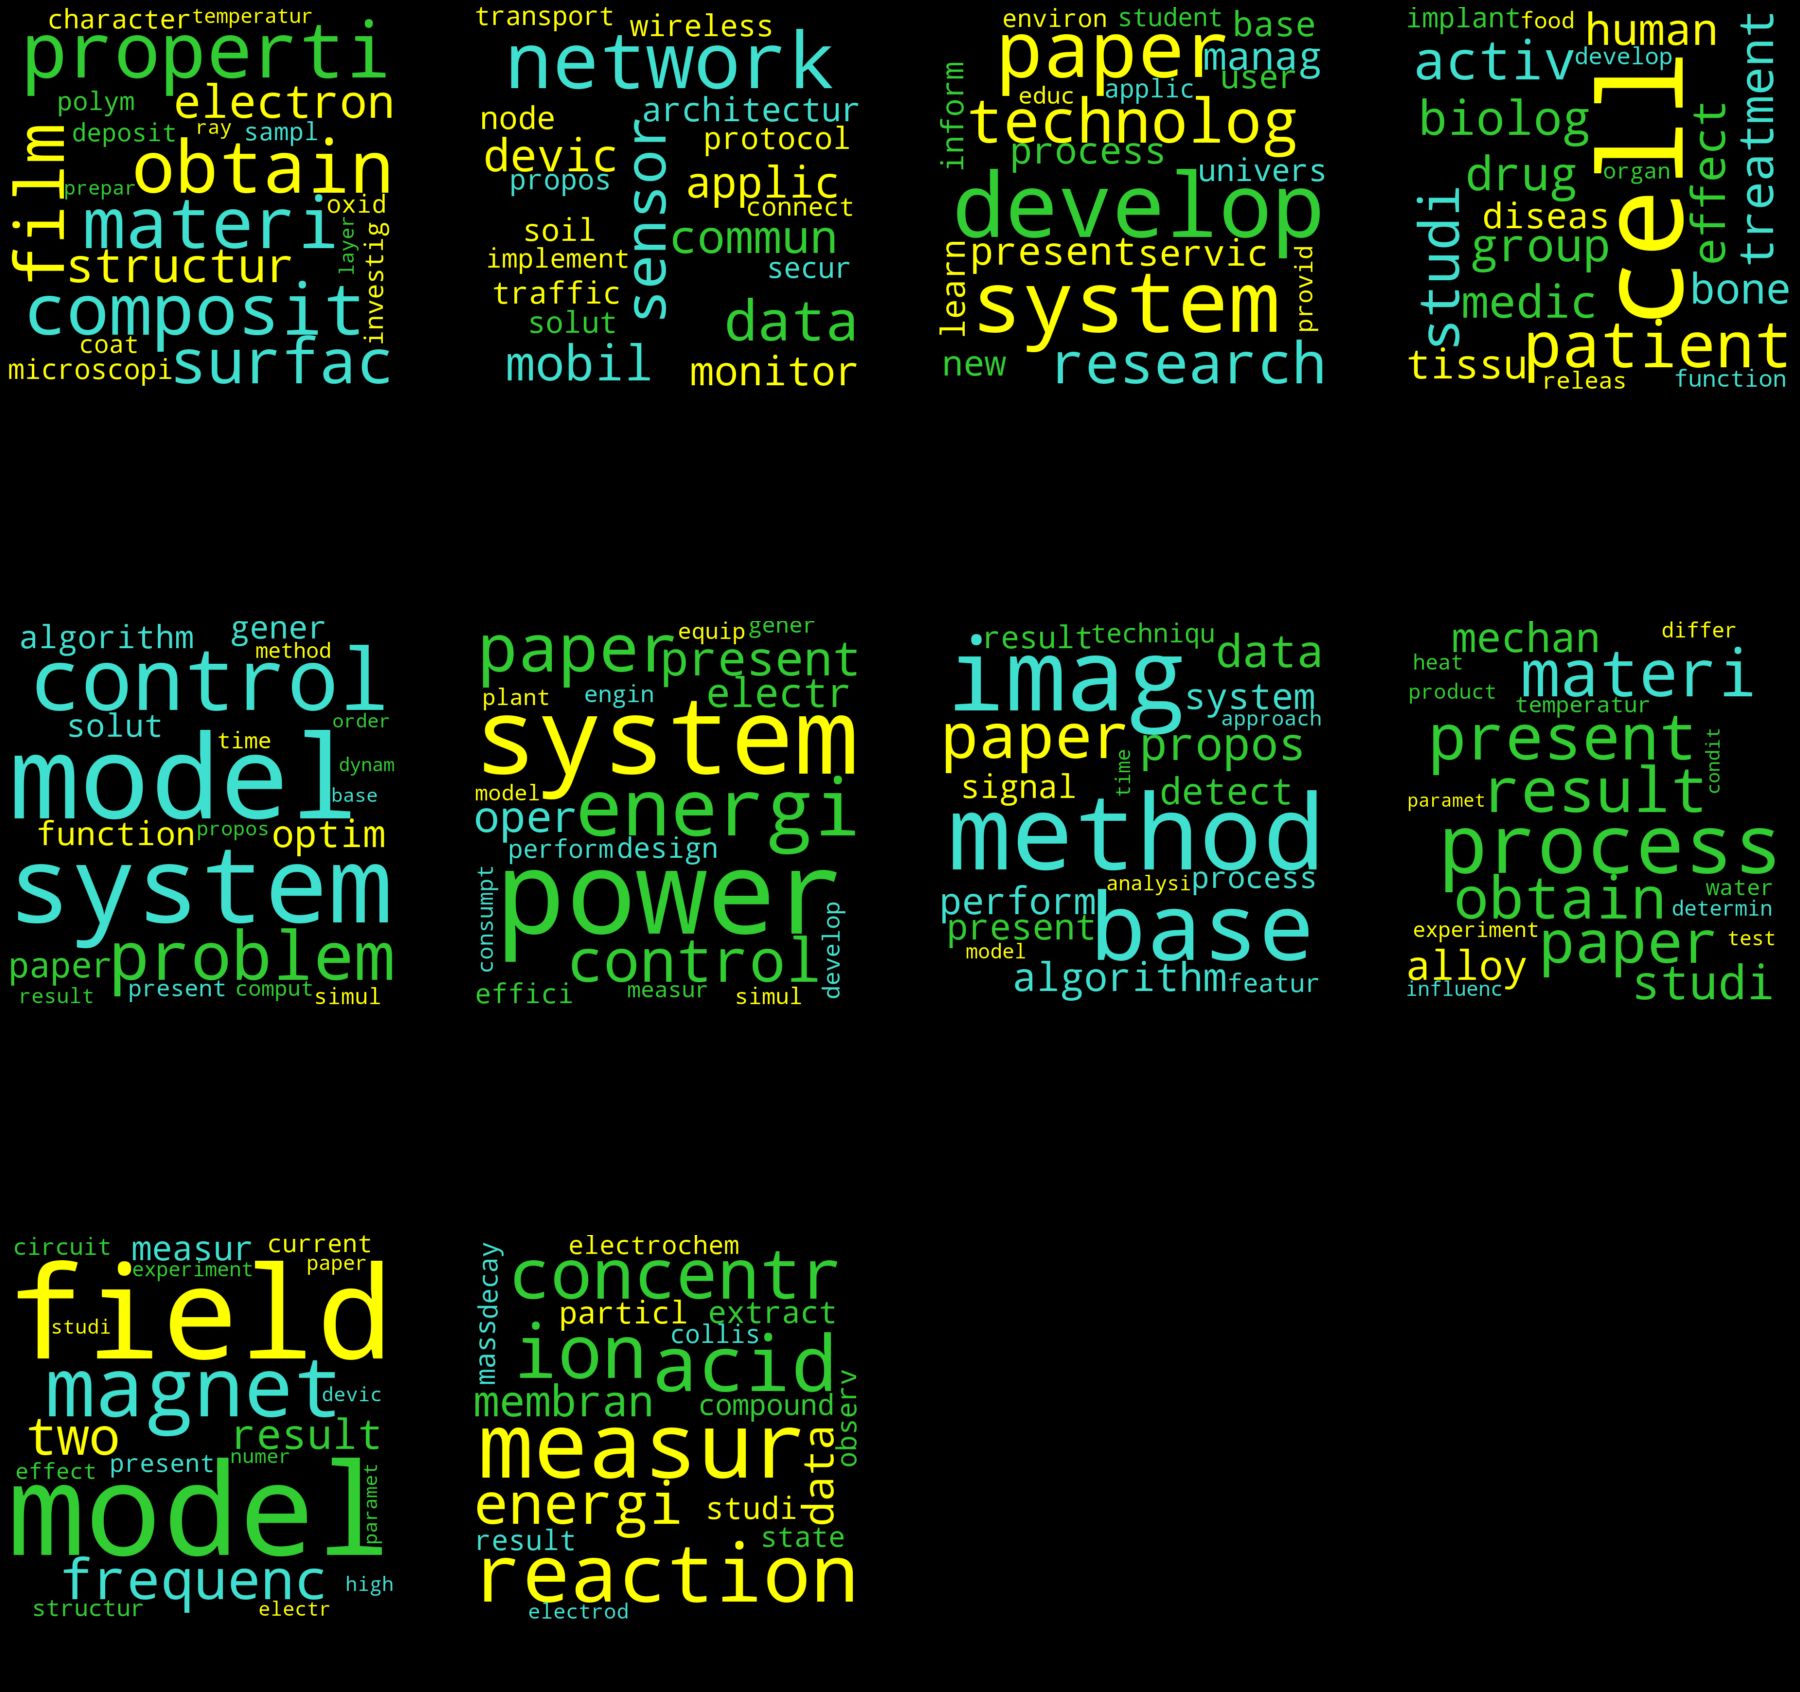

In [8]:
%matplotlib inline
if lda_visualize_results:
    train_lda.visualize_topics(lda, figsize=wc_figsize, coherence="c_npmi", colormap=colormap)

  0%|          | 0/16596 [00:00<?, ?it/s]

  0%|          | 0/2211 [00:00<?, ?it/s]

Model: ROC AUC=0.7856450907103316


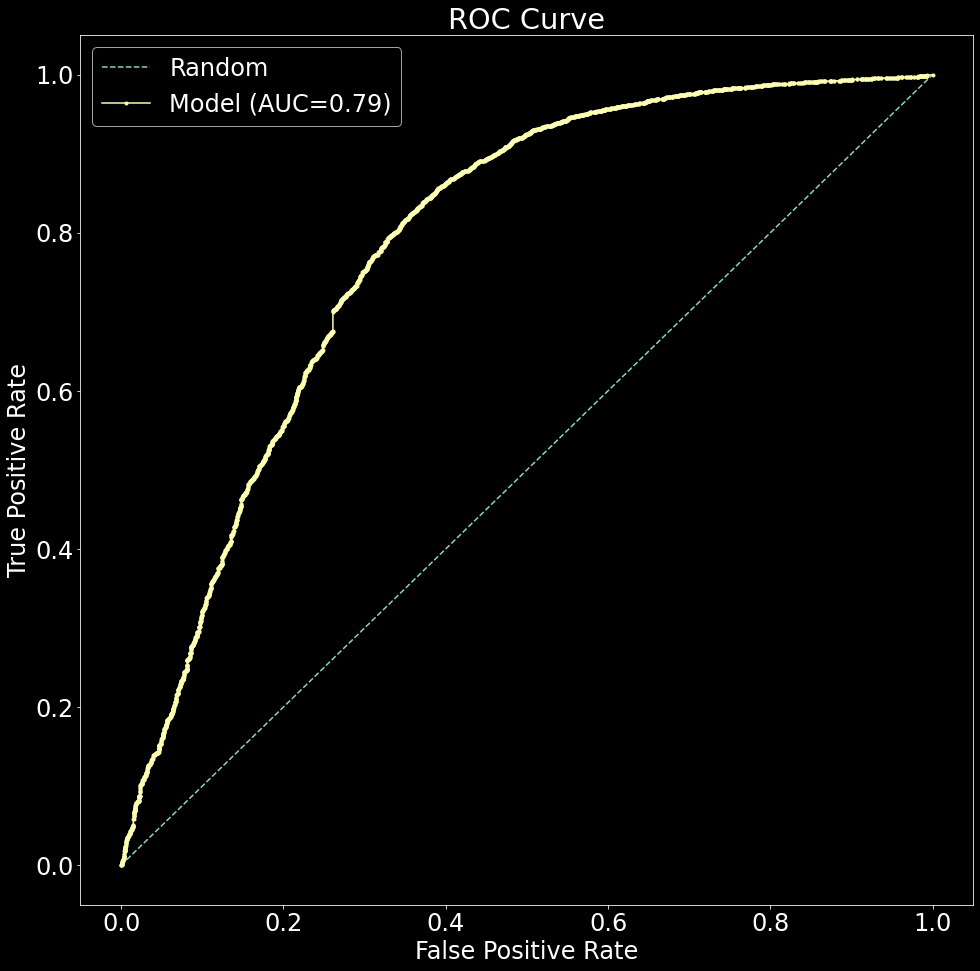

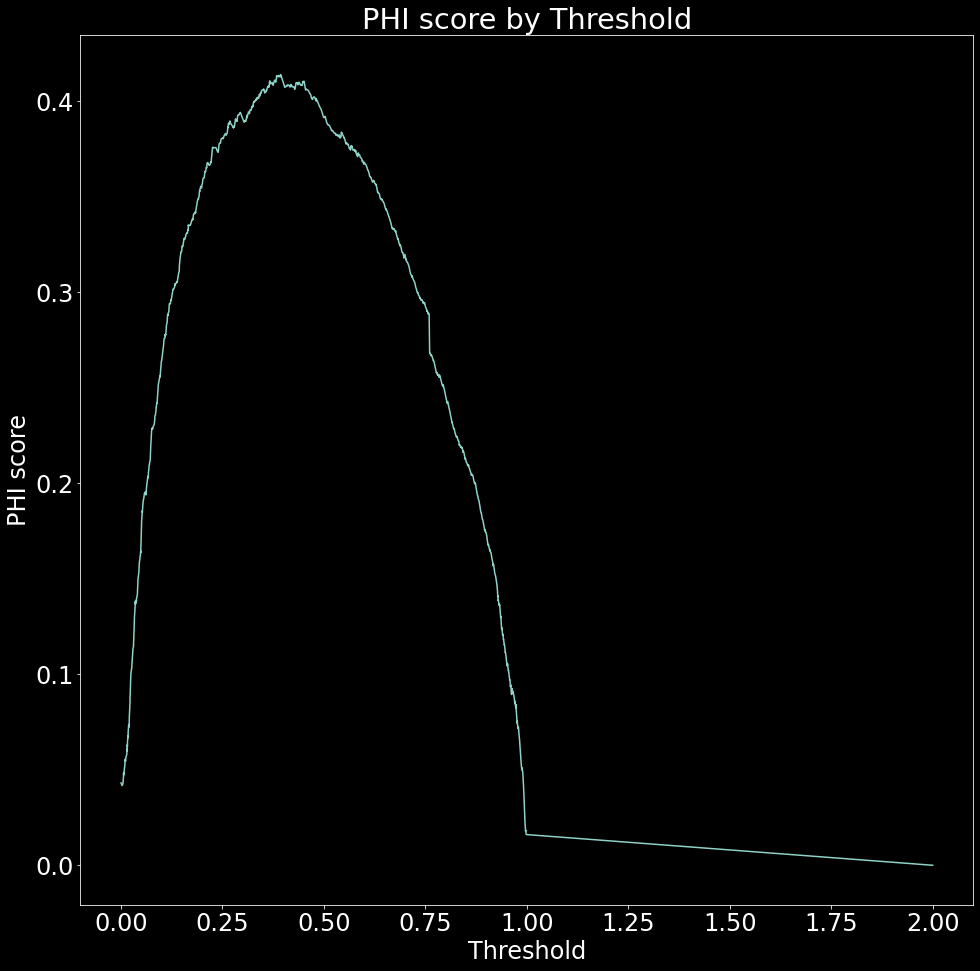

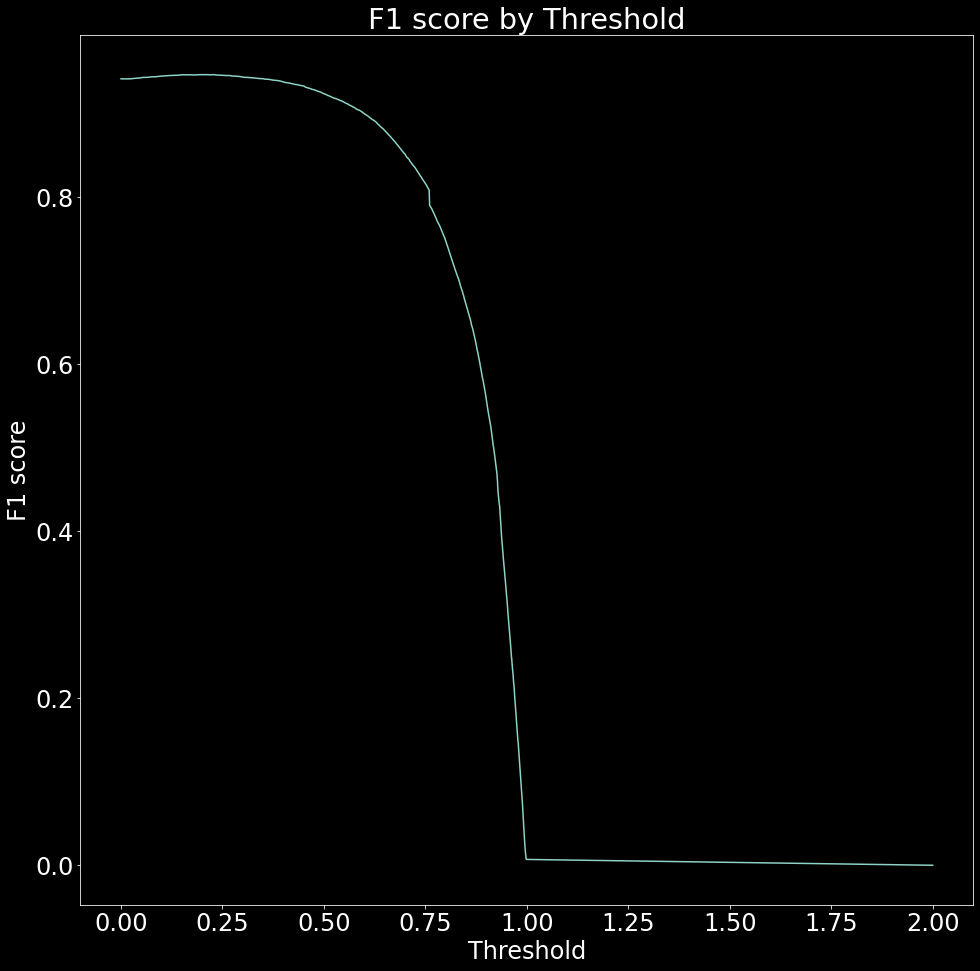

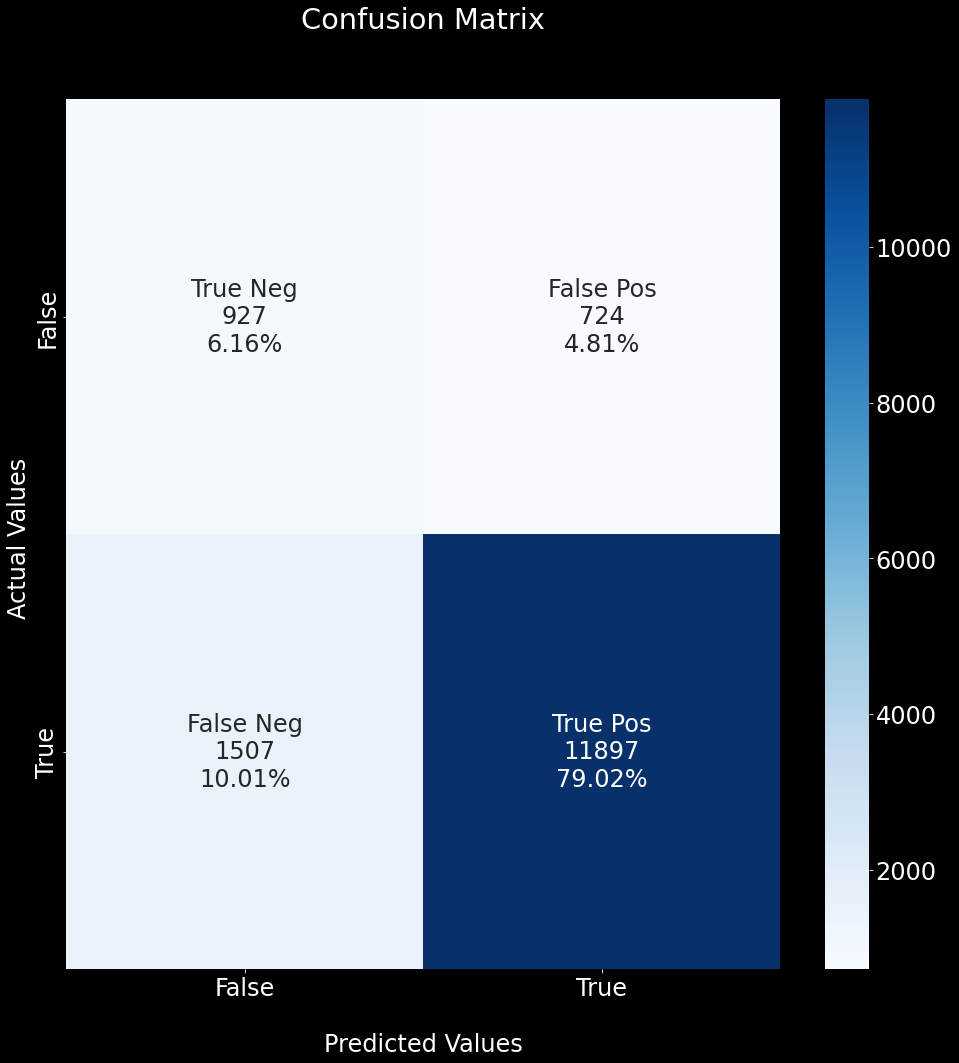

Precision: 0.8518100298904019
F1 score: 0.9468991551321229
Phi score: 0.4139883088020772


In [9]:
%reload user_profile
import user_profile
plt.rc('font', size=24)
if lda_visualize_results:
    positive_scores = user_profile.eval_topics_scores(publications_cv_lda,
                                                      users_features_lda, authors_cv,
                                                      progress=True,
                                                      metric=lda.cfg.metric)['score']
    negative_scores = user_profile.eval_topics_scores(publications_cv_lda,
                                                      users_features_lda,
                                                      authors_negative_cv,
                                                      progress=True,
                                                      metric=lda.cfg.metric)['score']
    fpr_samples = np.linspace(0, 1, 1000)
    auc, fpr_to_threshold, _ = user_profile.plot_roc_curve(positive_scores, negative_scores, plot=True,
                                                           fpr_samples=fpr_samples,
                                                           figsize=figsize)
    phi_score, best_threshold = user_profile.plot_score(positive_scores, negative_scores, plot=True,
                                                        figsize=figsize,
                                                        thresholds=fpr_to_threshold['threshold'].tolist(),
                                                        score="phi")
    f1_score, best_threshold = user_profile.plot_score(positive_scores, negative_scores, plot=True,
                                                       figsize=figsize,
                                                       thresholds=fpr_to_threshold['threshold'].tolist(),
                                                       score="f1")
    user_profile.plot_confusion_matrix(positive_scores, negative_scores, lda.cfg.threshold, figsize=figsize)
    tn, fp, fn, tp = user_profile.get_confusion_matrix(positive_scores, negative_scores,
                                                       lda.cfg.threshold).ravel()
    precision = user_profile.get_precision(tn, fp, fn, tp)
    print(f"Precision: {precision}")
    print(f"F1 score: {f1_score}")
    print(f"Phi score: {phi_score}")

  0%|          | 0/18804 [00:00<?, ?it/s]

  0%|          | 0/2483 [00:00<?, ?it/s]

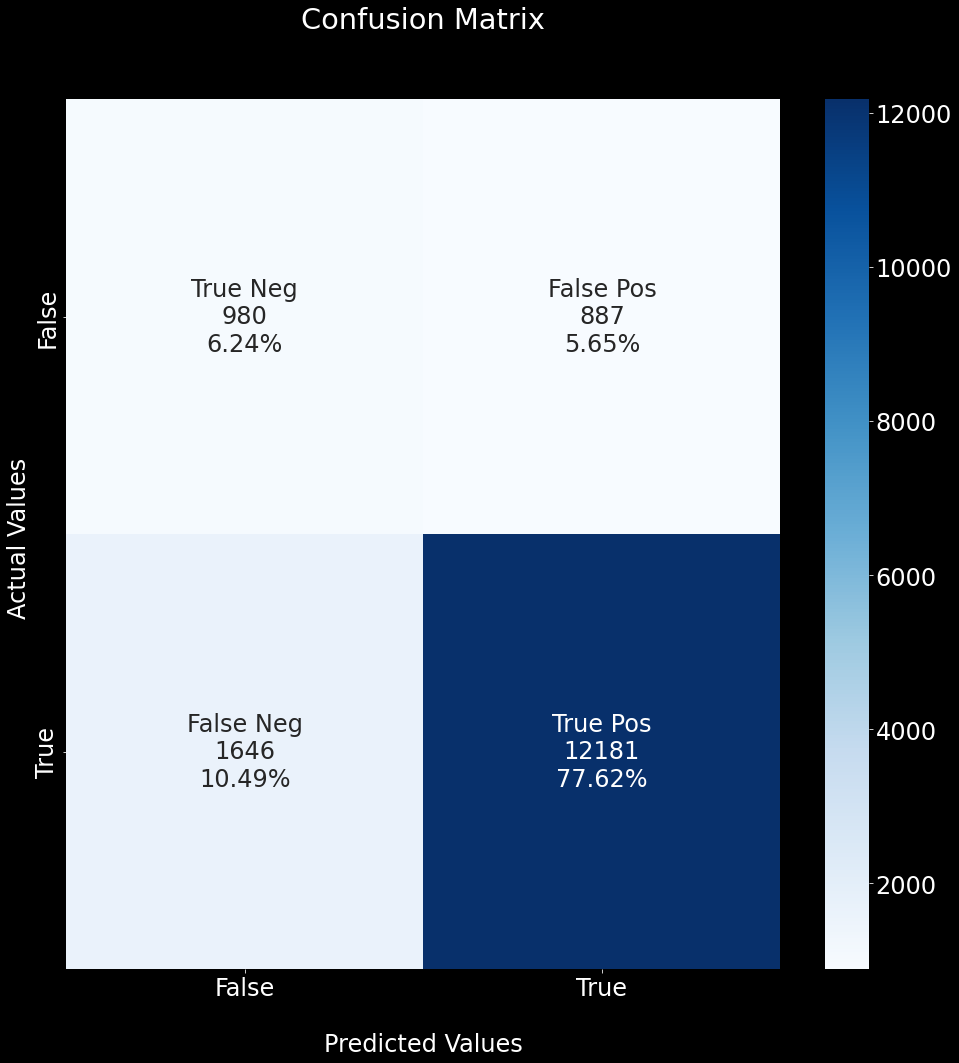

Precision: 0.8386007391359755
F1 score: 0.9058189254508274


In [10]:
if lda_visualize_test_results:
    publications_test_lda = train_lda.eval_lda(lda, publications_test)
    positive_scores = user_profile.eval_topics_scores(publications_test_lda,
                                                      users_features_lda,
                                                      authors_test,
                                                      progress=True,
                                                      metric=lda.cfg.metric)['score']
    negative_scores = user_profile.eval_topics_scores(publications_test_lda,
                                                      users_features_lda,
                                                      authors_negative_test,
                                                      progress=True,
                                                      metric=lda.cfg.metric)['score']
    user_profile.plot_confusion_matrix(positive_scores, negative_scores,
                                       lda.cfg.threshold, figsize=figsize)
    tn, fp, fn, tp = user_profile.get_confusion_matrix(positive_scores, negative_scores,
                                                       lda.cfg.threshold).ravel()
    precision = user_profile.get_precision(tn, fp, fn, tp)
    print(f"Precision: {precision}")
    f1 = user_profile.get_f1_score(tn, fp, fn, tp)
    print(f"F1 score: {f1}")

In [11]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Batches:   0%|          | 0/705 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/235 [00:00<?, ?it/s]

Model: ROC AUC=0.8259425010119593


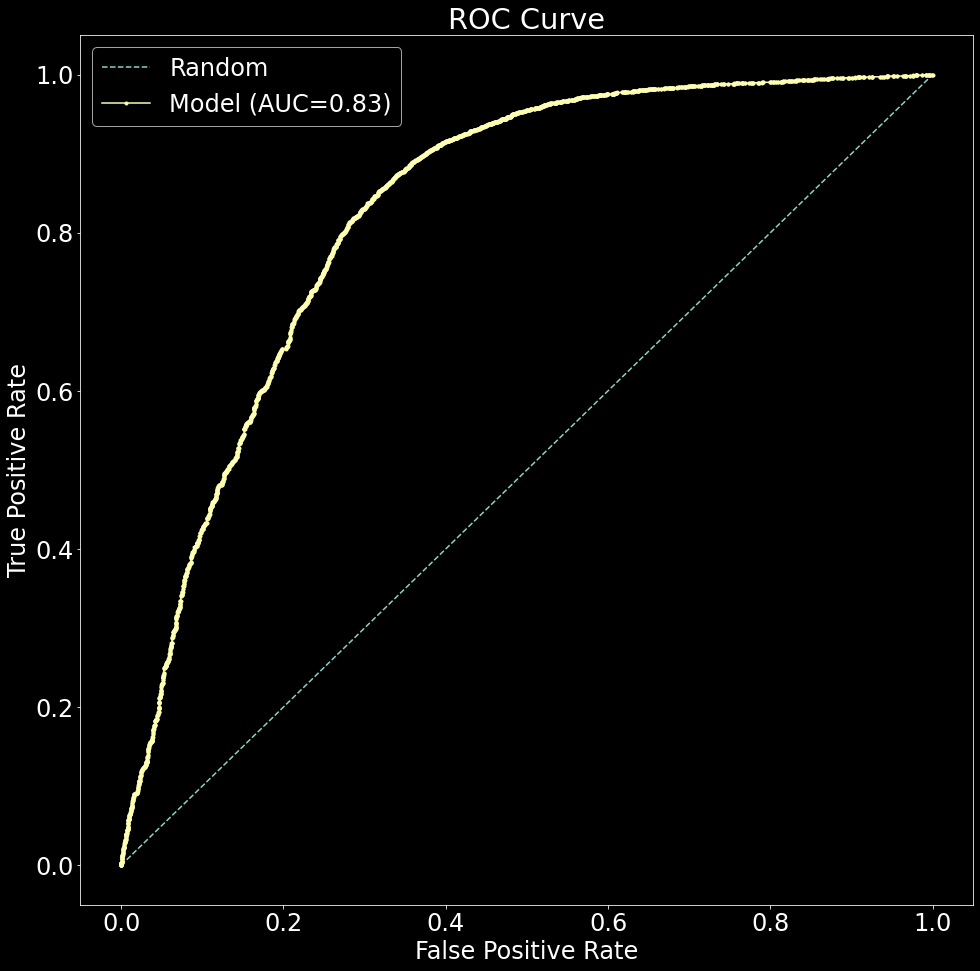

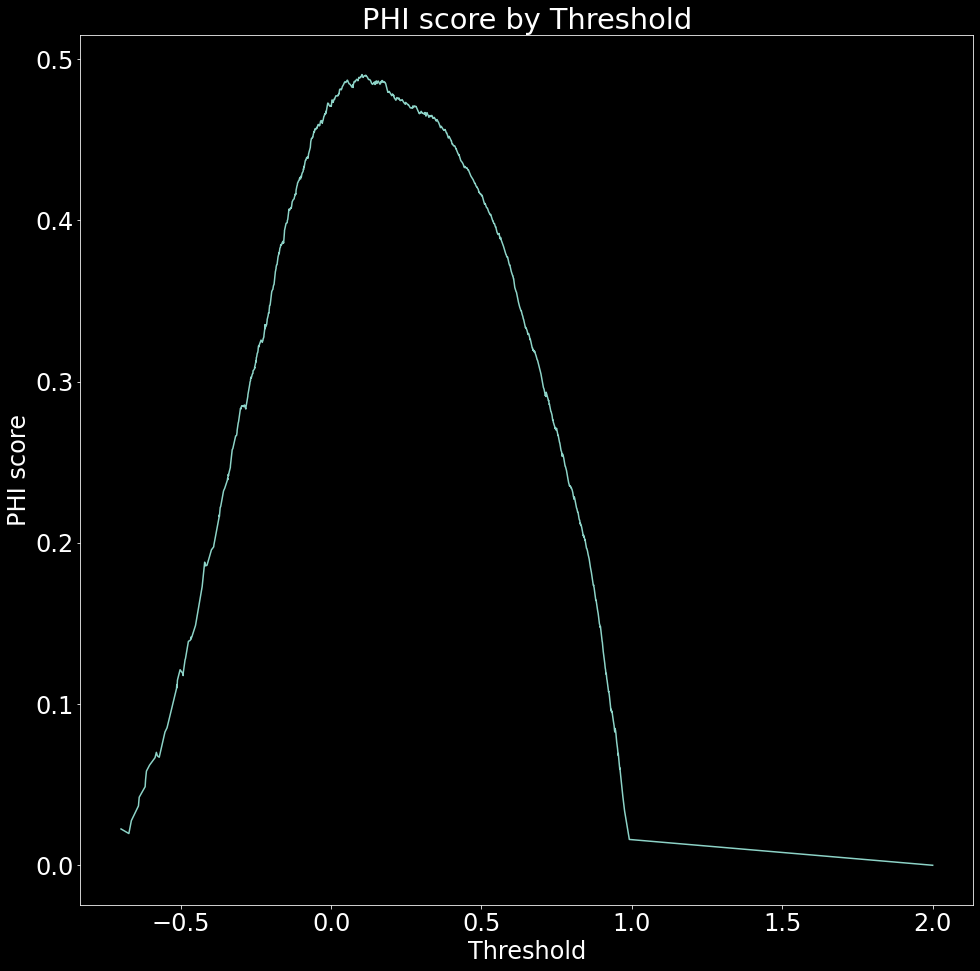

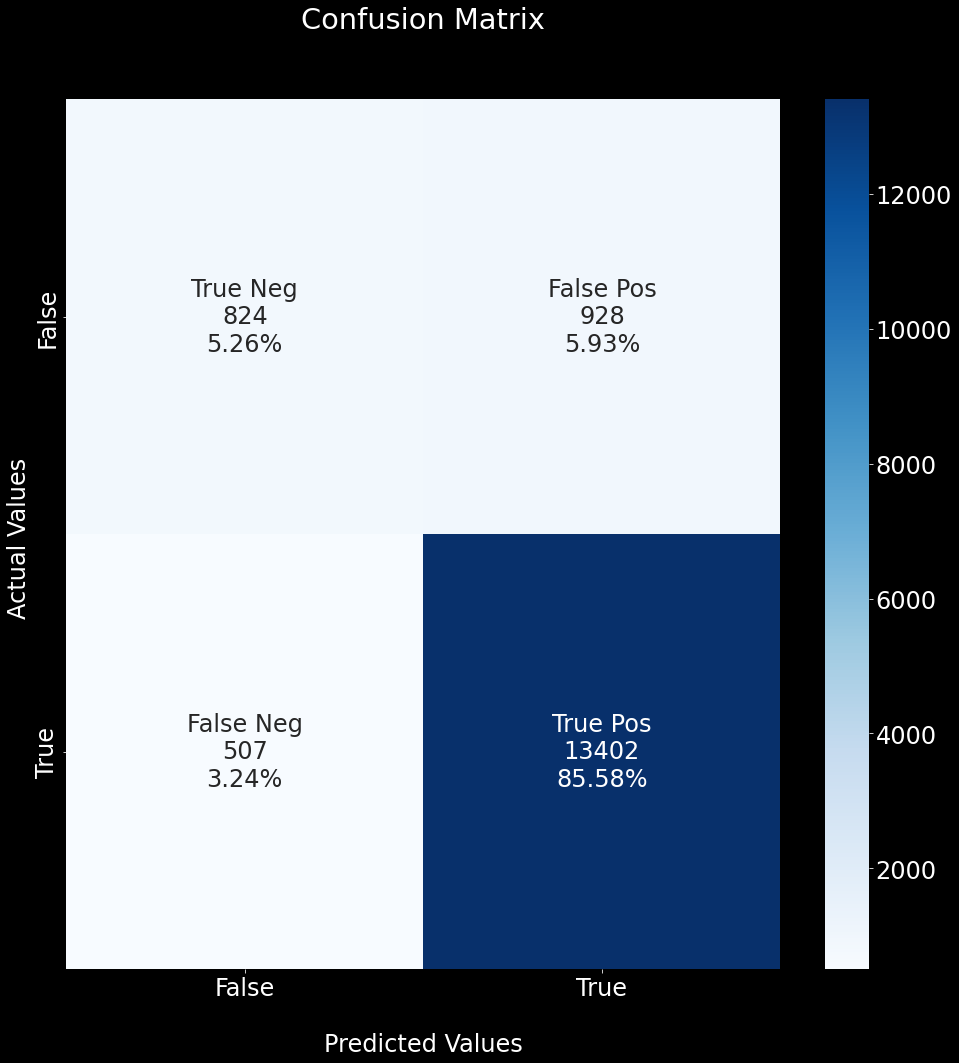

{'auc': 0.8259425010119593, 'phi_score': 0.4904118073394136, 'f1_score': 0.9491837529657565, 'precision': 0.9083711129557499, 'tn': 824, 'fp': 928, 'fn': 507, 'tp': 13402, 'embedding_model': 'all-MiniLM-L6-v2', 'device': 'cuda', 'n_components': 12, 'batch_size': 32, 'fpr_samples_from': 0, 'fpr_samples_to': 1, 'fpr_samples_count': 1000, 'threshold': 0.10273586958646774, 'normalize_features': False, 'threshold_overwrite': None, 'metric': 'cos', 'umap_metric': 'cosine', 'umap_n_neighbors': 10, 'umap_min_dist': 0, 'reducer': 'pca', 'verbose': False, 'use_scaler': False, 'clustering_algorithm': 'kmeans', 'n_clusters': 10, 'random_state': 42, 'score': 'phi'}
218.8003695011139


Batches:   0%|          | 0/235 [00:00<?, ?it/s]

257.8992726802826


/home/david/PycharmProjects/licenta/common.py:21: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['title', 'abstract_text', 'publication_type', 'no_pages', 'd_oi',
       'category', 'file_link', 'external_link', 'publisher', 'w_os',
       'jhi_type', 'keywords', 'publication_date', 'authors', 'metadata',
       'internal_link', 'photo_link', 'language', 'abstract_text_clean',
       'embeddings', 'embeddings_sentence_model', 'feature'],
      dtype='object')]

  df.to_hdf(f'{name}.hdf', key='df', mode='w')
/home/david/PycharmProjects/licenta/common.py:21: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['last_name', 'initials', 'first_name', 'email_address', 'jhi_type',
       'publication_features', 'publication_ids', 'f

In [12]:
import time
start = time.time()
if not bert_model_cached:
    bert_conf = train_bert.BERTConfig()
    bert_conf.embedding_model = "all-MiniLM-L6-v2"
    bert_conf.device = "cuda"
    bert_conf.n_components = 12
    bert_conf.batch_size = 32
    bert_conf.fpr_samples_from = 0
    bert_conf.fpr_samples_to = 1
    bert_conf.fpr_samples_count = 1000
    bert_conf.normalize_features = False
    bert_conf.metric = "cos"
    bert_conf.umap_metric = "cosine"
    bert_conf.reducer = "pca"
    bert_conf.use_scaler = False
    bert_conf.umap_min_dist = 0
    bert_conf.umap_n_neighbors = 10
    bert_conf.clustering_algorithm = "kmeans"
    bert_conf.n_clusters = 10
    bert_conf.random_state = 42
    bert_conf.score = "phi"

    bert, publications_bert_train, publications_bert_cv, authors_bert_cv,\
        authors_negative_bert_cv, users_features_bert, performance_report = \
        train_bert.train_and_evaluate_bert(\
            publications_bert_train, publications_bert_cv, authors_bert_train, authors_bert_cv,
            authors_negative_bert_cv, users, bert_conf, save_model=True, plot=True,
            random_negative_examples=False, recalculate_embeddings=False, progress=True,
            figsize=figsize)
    print(performance_report)
    print(time.time() - start)
    publications_bert_test = train_bert.eval_bert(bert, publications_bert_test,
                                                  recalculate_embeddings=False, progress=True)
    print(time.time() - start)

    common.save_dataframe(publications_bert_train, "publications_bert_train2")
    common.save_dataframe(publications_bert_cv, "publications_bert_cv2")
    common.save_dataframe(publications_bert_test, "publications_bert_test2")
    
    common.save_dataframe(authors_bert_cv, "authors_bert_cv")
    common.save_dataframe(authors_negative_bert_cv, "authors_negative_bert_cv")
    common.save_dataframe(users_features_bert, "users_features_bert")
else:
    publications_bert_train = common.load_dataframe("publications_bert_train2")
    publications_bert_cv = common.load_dataframe("publications_bert_cv2")
    publications_bert_test = common.load_dataframe("publications_bert_test2")
    
    authors_bert_cv = common.load_dataframe("authors_bert_cv")
    authors_negative_bert_cv = common.load_dataframe("authors_negative_bert_cv")
    users_features_bert = common.load_dataframe("users_features_bert")
    
    bert = train_bert.load_bert_model()

100%|████████████████████████████████████████████████████████████████| 22533/22533 [00:01<00:00, 18743.09it/s]


Batches:   0%|          | 0/1907 [00:00<?, ?it/s]

/home/david/PycharmProjects/licenta/common.py:86: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

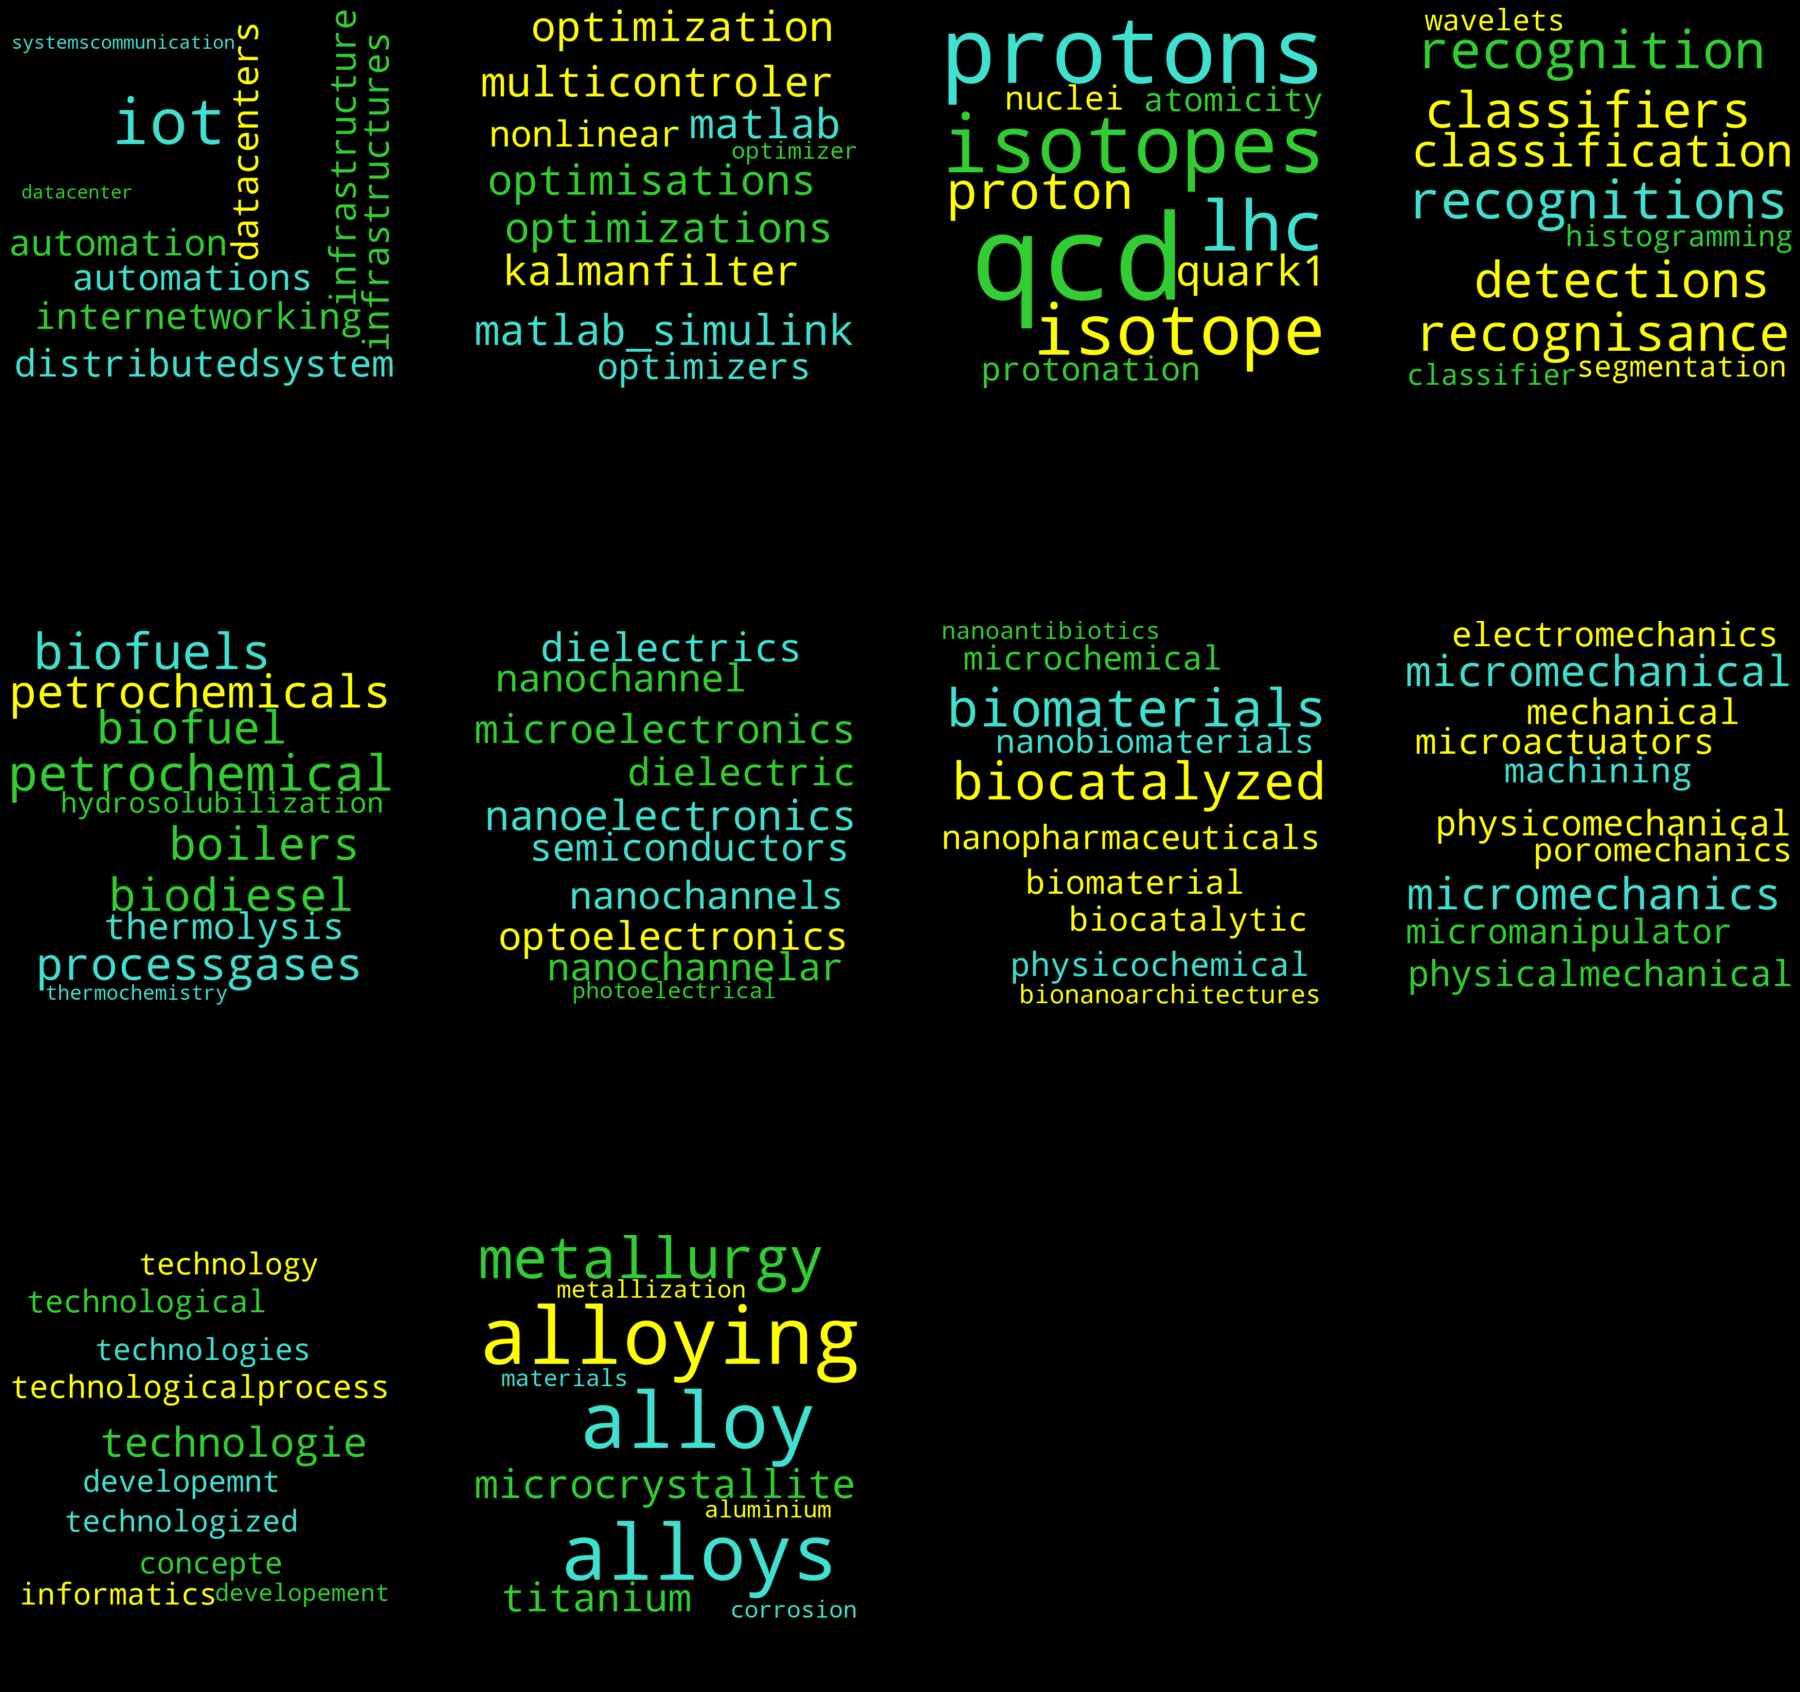

In [13]:
%reload train_bert
import train_bert

if bert_visualize_results:
    try:
        word_embeddings
        words
    except NameError:
        word_embeddings = None
        words = None

    coherence, word_embeddings, words = \
        train_bert.get_coherence(
            bert, publications_bert_train_abstracts=publications_bert_train['abstract_text_clean'],
            word_embeddings=word_embeddings, words=words, coherence="c_npmi",
            plot=True, figsize=wc_figsize, top_words=10, colormap=colormap)
    print(f"Coherence = {coherence}")

  0%|          | 0/13909 [00:00<?, ?it/s]

  0%|          | 0/1752 [00:00<?, ?it/s]

Model: ROC AUC=0.8259425010119593


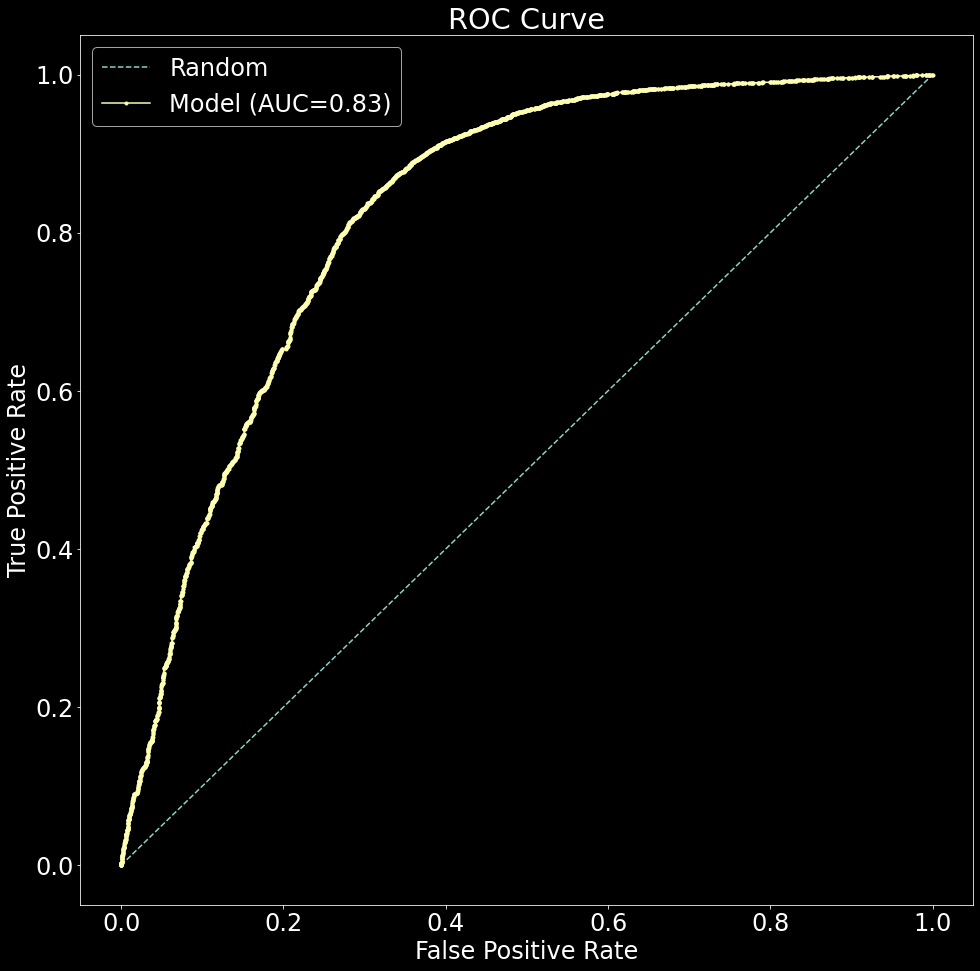

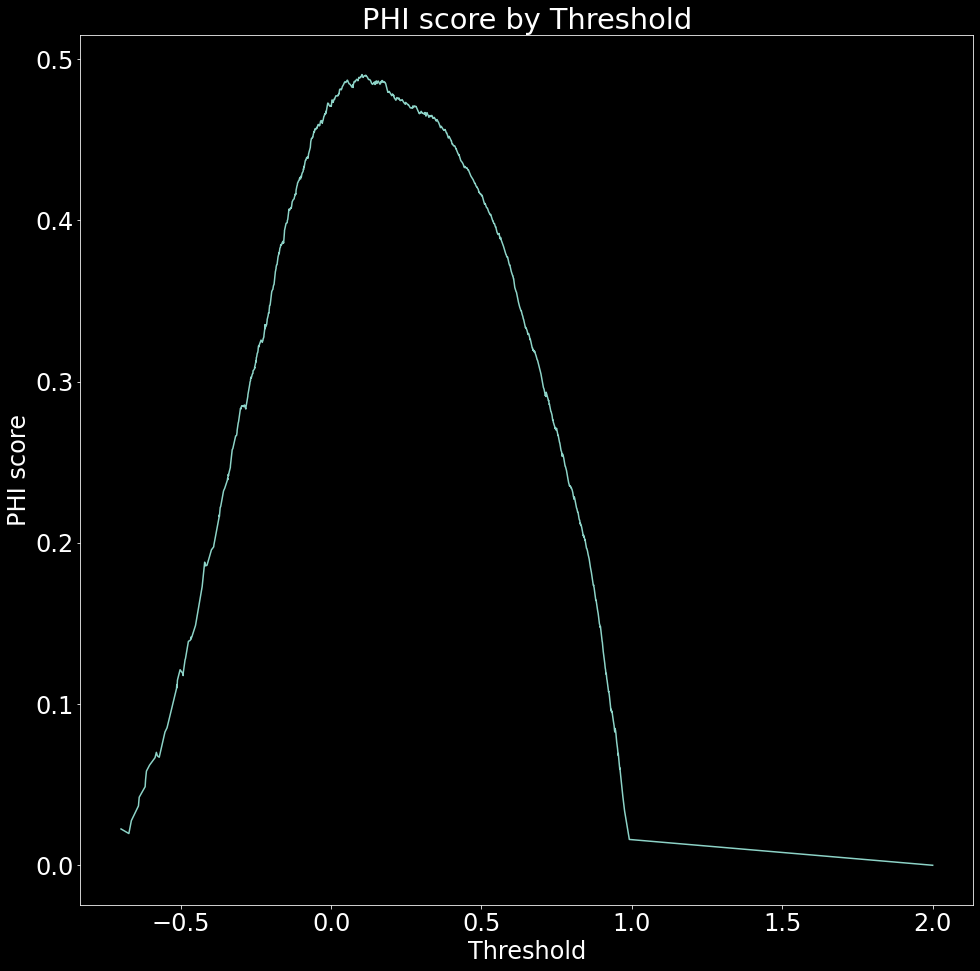

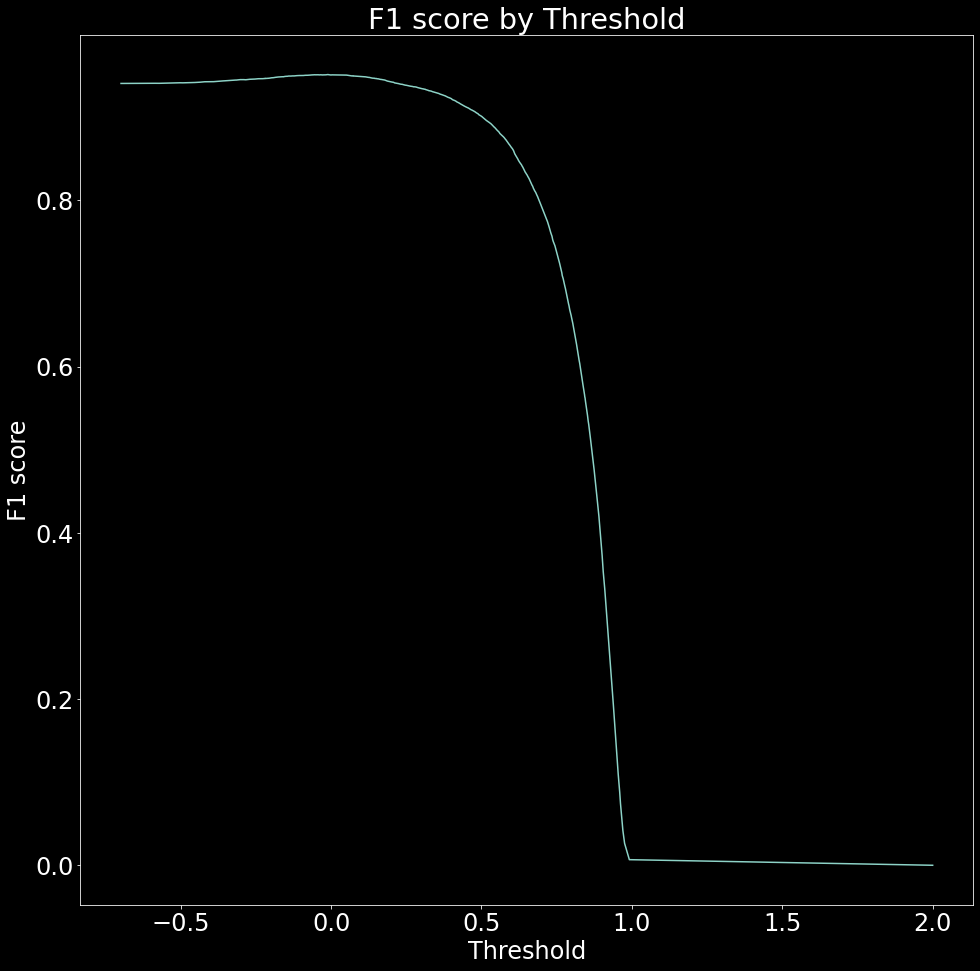

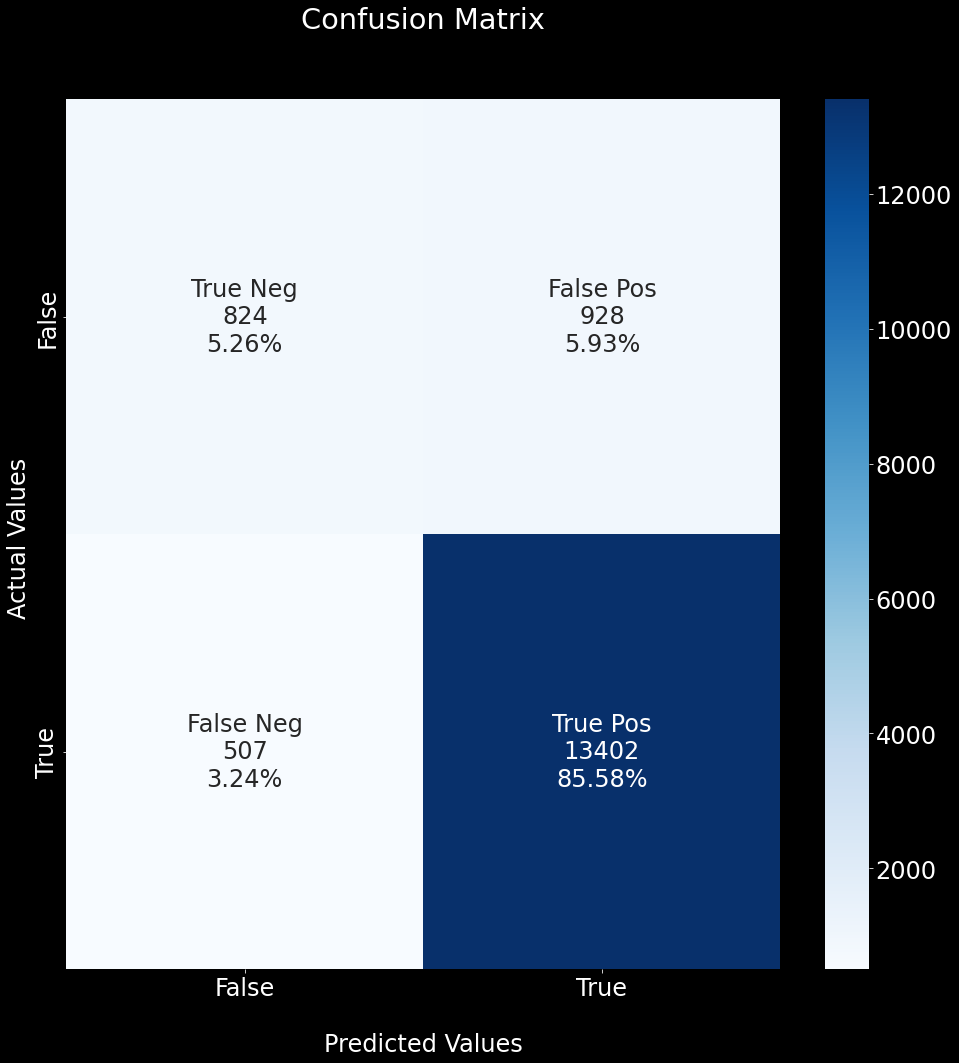

Precision: 0.9083711129557499
F1 score: 0.9514542718140773
Phi score: 0.4904118073394136


In [14]:
if bert_visualize_results:
    positive_scores = user_profile.eval_topics_scores(publications_bert_cv, users_features_bert,
                                                      authors_bert_cv,
                                                      progress=True,
                                                      metric=bert.cfg.metric)['score']
    negative_scores = user_profile.eval_topics_scores(publications_bert_cv,
                                                      users_features_bert,
                                                      authors_negative_bert_cv,
                                                      progress=True,
                                                      metric=bert.cfg.metric)['score']
    fpr_samples = np.linspace(0, 1, 1000)
    auc, fpr_to_threshold, _ = user_profile.plot_roc_curve(positive_scores, negative_scores, plot=True,
                                                           fpr_samples=fpr_samples,
                                                           figsize=figsize)
    phi_score, best_threshold = user_profile.plot_score(positive_scores, negative_scores, plot=True,
                                                        figsize=figsize,
                                                        thresholds=fpr_to_threshold['threshold'].tolist(),
                                                        score="phi")
    f1_score, best_threshold = user_profile.plot_score(positive_scores, negative_scores, plot=True,
                                                       figsize=figsize,
                                                       thresholds=fpr_to_threshold['threshold'].tolist(),
                                                       score="f1")
    user_profile.plot_confusion_matrix(positive_scores, negative_scores,
                                       bert.cfg.threshold,
                                       figsize=figsize)
    tn, fp, fn, tp = user_profile.get_confusion_matrix(positive_scores, negative_scores,
                                                       bert.cfg.threshold).ravel()
    precision = user_profile.get_precision(tn, fp, fn, tp)
    print(f"Precision: {precision}")
    print(f"F1 score: {f1_score}")
    print(f"Phi score: {phi_score}")

  0%|          | 0/19078 [00:00<?, ?it/s]

  0%|          | 0/2373 [00:00<?, ?it/s]

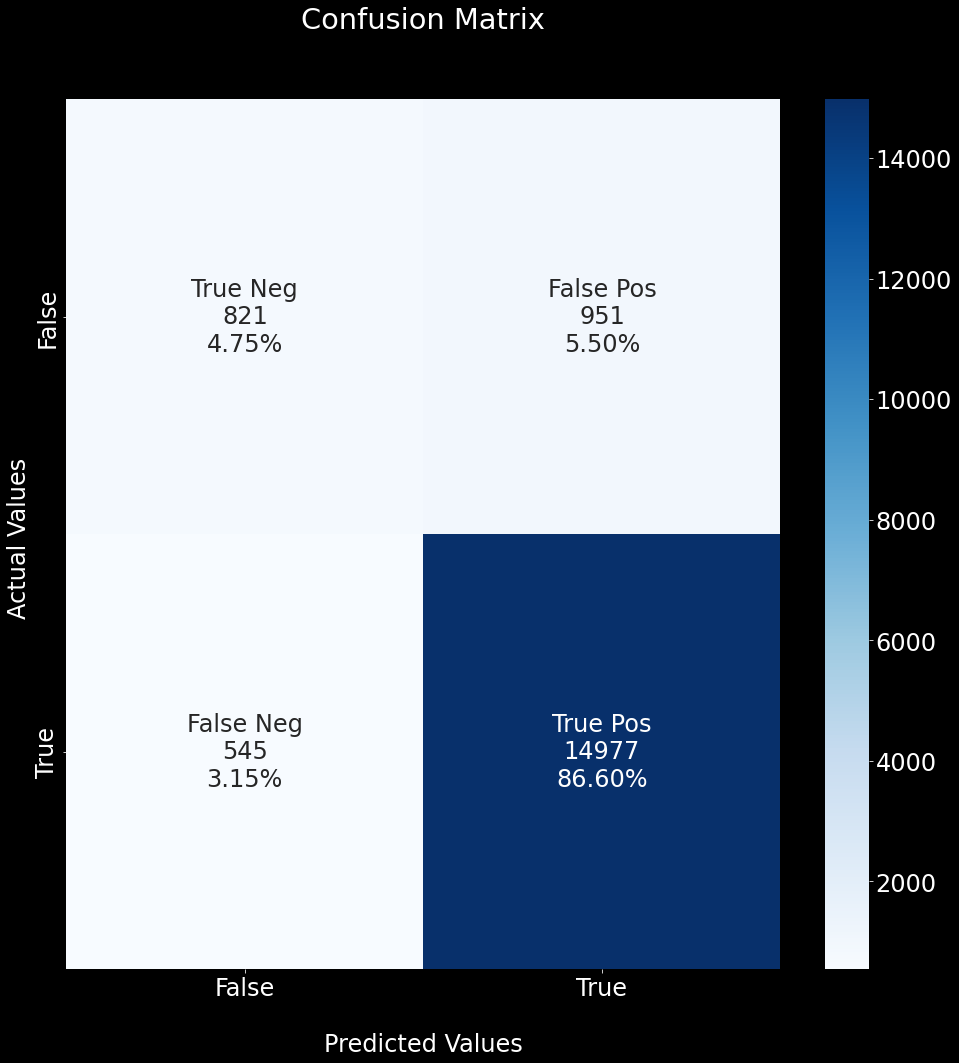

Precision: 0.9134960101769399
F1 score: 0.9524324324324325


In [15]:
if bert_visualize_test_results:
    threshold = bert.cfg.threshold
    positive_scores = user_profile.eval_topics_scores(publications_bert_test, users_features_bert,
                                                      authors_bert_test,
                                                      progress=True, metric=bert.cfg.metric)['score']
    negative_scores = user_profile.eval_topics_scores(publications_bert_test,
                                                      users_features_bert,
                                                      authors_negative_bert_test,
                                                      progress=True,
                                                      metric=bert.cfg.metric)['score']
    user_profile.plot_confusion_matrix(positive_scores, negative_scores, threshold, figsize=figsize)
    tn, fp, fn, tp = user_profile.get_confusion_matrix(positive_scores, negative_scores,
                                                       threshold).ravel()
    precision = user_profile.get_precision(tn, fp, fn, tp)
    print(f"Precision: {precision}")
    f1 = user_profile.get_f1_score(tn, fp, fn, tp)
    print(f"F1 score: {f1}")


====== False Negative ======

The class of biomaterials (metallic, polymer or ceramics) has applications as implants with a temporary function. Among magnezium (high corrosion rate) and iron (slow corrosion rate) based biodegradable alloys a new class based on zinc try to fullfill the gap between the first two alloy systems concerning the degradation rate. The role of these alloys is to provide some specific characteristics for a limited period of time. In this article preliminary results based on microstructural and chemical characteristics of a Zn-Mg alloy are presented. The results were obtained using optical and electronic microscopy (MO and SEM) and dispersive energy spectroscpy (EDS) and X-ray difraction (XRD).

====== True user publications ======

['The paper presents the results of a theoretical thermodynamic study carried out to substitute the non-ecological refrigerant in a single-stage vapor compression refrigeration system (VCRS). It is proposed to uses working fluids mix

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

                          similarity
biomaterials metallic       0.591542
mg alloy                    0.469947
alloy                       0.468319
alloys                      0.453472
biodegradable alloys        0.444174
corrosion                   0.441756
microstructural chemical    0.438476
alloys new                  0.437493
alloy systems               0.436866
biomaterials                0.436686
ceramics applications       0.435705
class biomaterials          0.434311
alloys provide              0.433247
role alloys                 0.422293
alloy presented             0.419433
gap alloy                   0.418106
high corrosion              0.408393
corrosion rate              0.400813
slow corrosion              0.387435
ceramics                    0.386567

====== User keywords ======



Batches:   0%|          | 0/39 [00:00<?, ?it/s]

                            similarity
thermal efficiency            0.517726
optimization thermodynamic    0.479580
process heat                  0.464863
maximum efficiency            0.462493
rankine cycle                 0.449064
convert heat                  0.440378
thermodynamic study           0.433334
using rankine                 0.430187
industrial refrigeration      0.427135
heat transfer                 0.426035
energy conversion             0.425751
power rankine                 0.424755
thermodynamic approach        0.423802
process simulation            0.421518
energy systems                0.418948
energy management             0.415409
internal combustion           0.407299
transfer gas                  0.402954
fluids rankine                0.400917
increment thermal             0.396996
User Profile:
[-0.01976037  0.27589926  0.07734127 -0.08921209  0.14762388  0.06174352
 -0.03639611 -0.13197692 -0.00037278 -0.03322182  0.14916056 -0.02856506]
Publication Feature:

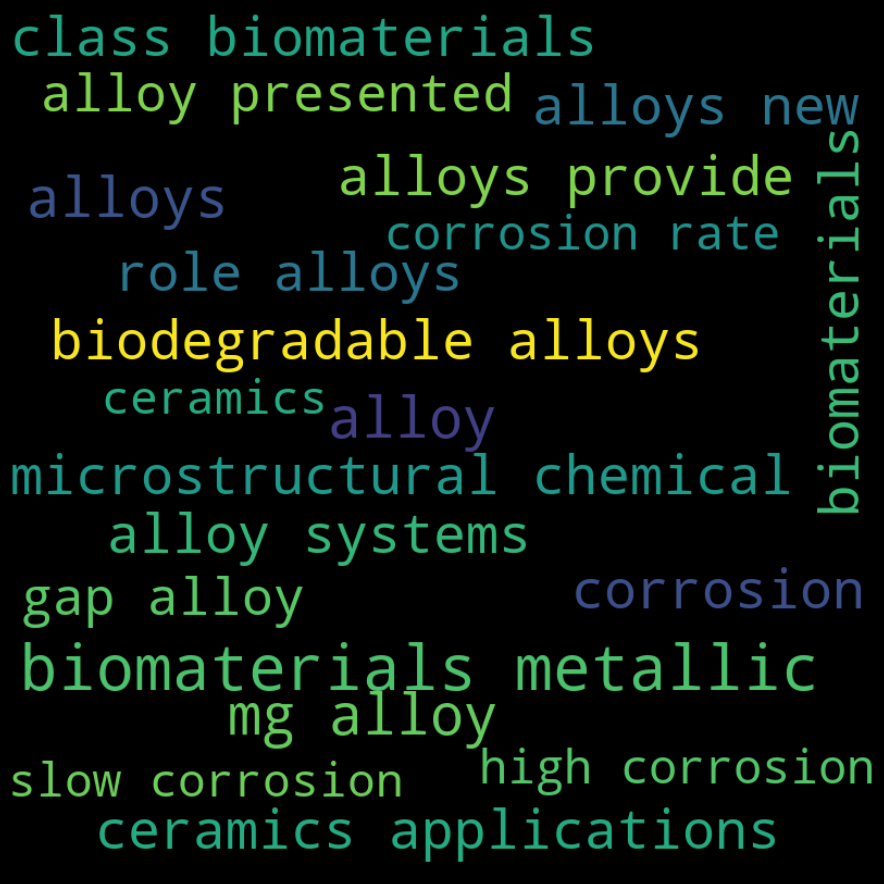

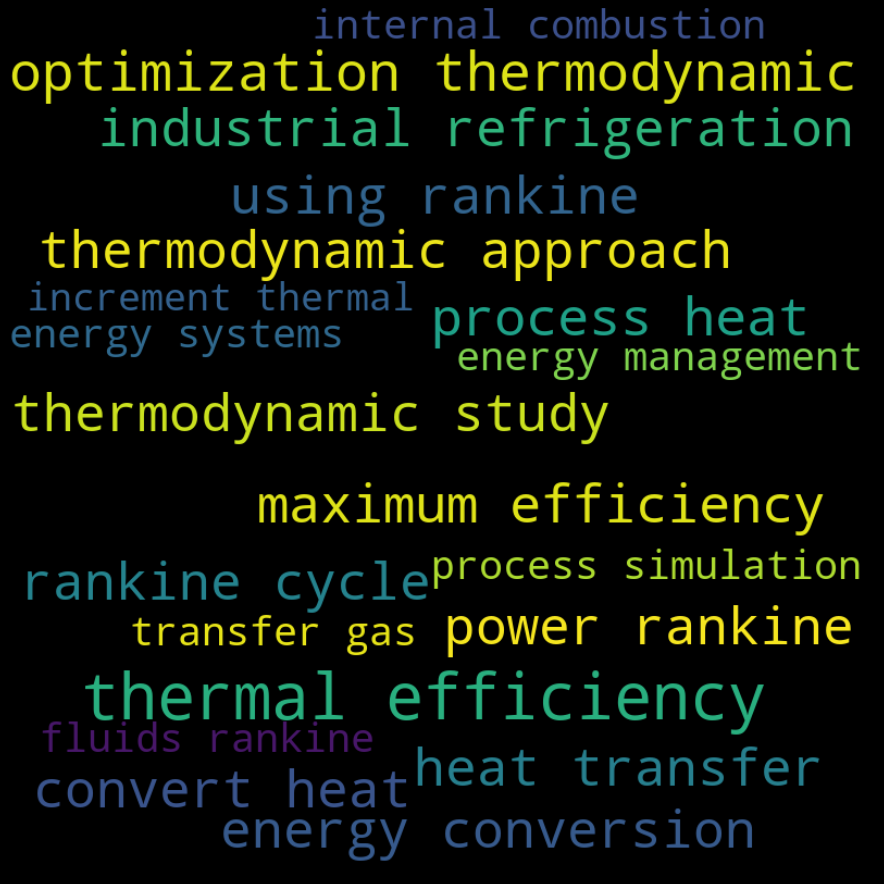

In [172]:
%reload common
import common

random_state = None
target = 'false_negative'

false_positives = authors_negative_bert_cv[authors_negative_bert_cv['score'] > 0]
false_negatives = authors_bert_cv[authors_bert_cv['score'] <= 0]
if target == 'false_positive':
    sample = false_positives.sample(1, random_state=random_state)
else:
    sample = false_negatives.sample(1, random_state=random_state)
pub_sample = publications_bert_cv.loc[sample['publication_id']]
pub = pub_sample.iloc[0]
user = users_features_bert.loc[sample['user_id']].iloc[0]
user_publications = common.publications_for_user(publications_bert_train, authors_bert_train, user.name)
if target == 'false_positive':
    print("\n====== False Positive ======\n")
else:
    print("\n====== False Negative ======\n")
print(pub['abstract_text'])
print("\n====== True user publications ======\n")
print(user_publications['abstract_text'].tolist())

print("\n====== Paper keywords ======\n")
print(train_bert.get_top_words(bert, pub['feature'], publications=pub_sample,
                               ngram_range=(1, 2), figsize=figsize, plot=True))

print("\n====== User keywords ======\n")
print(train_bert.get_top_words(bert, user['profile'], publications=user_publications,
                               ngram_range=(1, 2), figsize=figsize, plot=True))
print("User Profile:")
print(user['profile'])
print("Publication Feature:")
print(pub['feature'])
print(f"Similarity: {user_profile.eval_score_simple(user['profile'], pub['feature'], bert.cfg.metric)}")
print(f"Threshold : {bert.cfg.threshold}")

In [68]:
# Ciprian Dobre - 534
# Cornel Popescu - 779
# Victor Asavei - 1634
# Traian Rebedea - 1472
users_features_bert[users_features_bert['last_name'] == '??']

Empty DataFrame
Columns: [last_name, initials, first_name, email_address, jhi_type, researchers_id, collaborators_id, phd_students_id, roles_id, students_id, curs_id, publication_features, publication_ids, features_mean, features_std, profile, num_publications]
Index: []

  0%|          | 0/1 [00:00<?, ?it/s]

Negative example


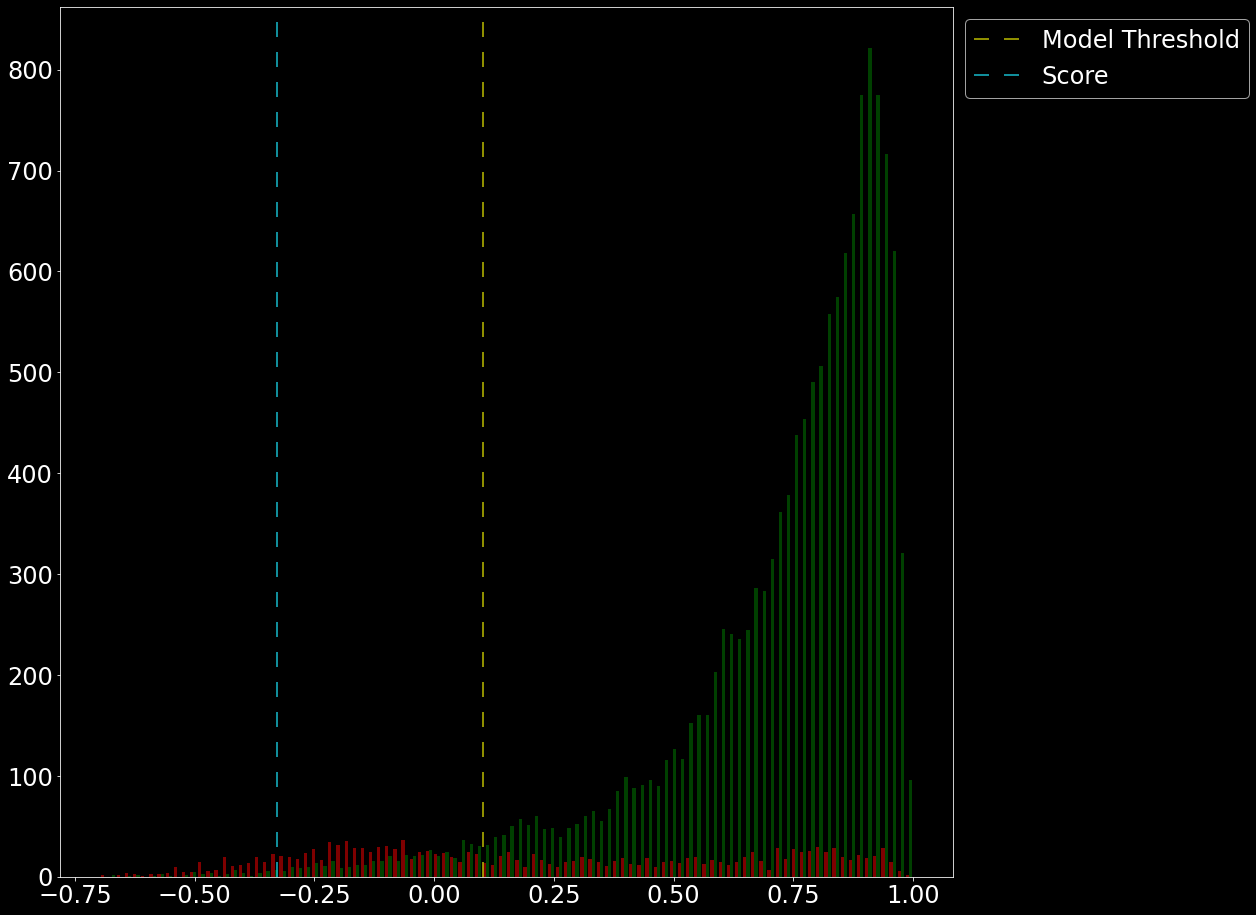

In [36]:
%reload train_bert
import train_bert

user_id = 779
abstract = "<jats:p>This study reports the fabrication of nanostructured coatings based on magnetite, polyethyleneglycol, and biologically active molecule (polymyxin B-PM) for producing biofilm-resistant surfaces (voice prosthesis). Magnetite nanoparticles (MNPs) have been synthesized and functionalized using a co-precipitation method and were further deposited into thin coatings using the matrix-assisted pulsed laser evaporation (MAPLE) technique. The obtained nanoparticles and coatings were characterized by X-ray diffraction (XRD), thermogravimetric analysis with differential scanning calorimetry (TGA-DSC), scanning electron microscopy (SEM), transmission electron microscopy with selected area electron diffraction (TEM-SAED), Fourier-transform infrared spectroscopy (FT-IR), and infrared microscopy (IRM). Their antibiofilm activity was tested against relevant Staphylococcus aureus and Pseudomonas aeruginosa bacterial strains. The Fe3O4@PEG/PM surface of modified voice prosthesis sections reduced the number of CFU/mL up to four orders of magnitude in the case of S. aureus biofilm. A more significant inhibitory effect is noticed in the case of P. aeruginosa up to five folds. These results highlight the importance of new Fe3O4@PEG/PM in the biomedical field.</jats:p>"

if user_id not in users_features_bert.index:
    print("User not in dataset")
else:
    demo_publication = train_bert.eval_bert_unprocessed(bert, abstract, progress=False)
    demo_scores = user_profile.eval_topics_scores(demo_publication, users_features_bert,
                                                  pd.DataFrame({'user_id': [user_id], 'publication_id': [0]}),
                                                  progress=False, metric=bert.cfg.metric)['score']

    if all(demo_scores >= bert.cfg.threshold):
        print("Positive example")
    else:
        print("Negative example")

    plt.figure(figsize=(16, 16))
    plt.hist([authors_negative_bert_cv['score'], authors_bert_cv['score']],
                 color=['r','g'], alpha=0.5, bins=100)
    plt.axvline(x=bert.cfg.threshold, color='y', label='Model Threshold', dashes=(10, 10))
    if len(demo_scores) > 0:
        plt.axvline(x=demo_scores.iloc[0], color='tab:cyan', label=f'Score', dashes=(10, 10))
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

In [30]:
num_publications = len(users_features_bert.loc[user_id]['publication_ids'])
print(f"{num_publications} publications")
users_features_bert.loc[user_id]['publication_ids']

9 publications


[33111, 21138, 21140, 21134, 21139, 21136, 21141, 21142, 77971]

In [31]:
publications_bert_train.loc[users_features_bert.loc[user_id]['publication_ids']]['abstract_text'].tolist()

['A simple mechanical approach to describe motion with linear drag of a pulsejet-equipped system (PES) in gravitational field is introduced. The lift force is neglected and the fluid is expelled with constant speed relative to the engine into the opposite direction of the PES direction of motion. The thrust is explained by the linear momentum conservation law applied to the intake/expulsion processes, assumed as instantaneous and periodic. Analytical expressions are obtained for the trajectory and velocity of the PES. The convergence of a 2D sequence recurrently defined by a non-linear relation and involved in these expressions is proved, showing the remarkable fact that in a non-vertical upward launch the PES necessarily returns to the initial height it started at with a downward velocity. The approach is applied to simulate the kinematics of some jetting paralarva species. The paper is addressed to intermediate',
 'Granular-fluid gravity driven flow down arbitrary topographic terrain


====== User keywords ======



Batches:   0%|          | 0/14 [00:00<?, ?it/s]

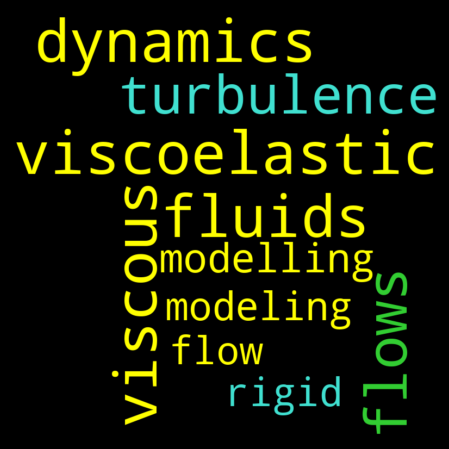

In [32]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

user = users_features_bert.loc[user_id]
user_publications = common.publications_for_user(publications_bert_train, authors_bert_train, user.name)

print("\n====== User keywords ======\n")
_ = train_bert.get_top_words(bert, user['profile'], publications=user_publications,
                             ngram_range=(1, 1), figsize=(8, 8), plot=True, top_words=10,
                             colormap=colormap)


====== Paper keywords ======



Batches:   0%|          | 0/3 [00:00<?, ?it/s]

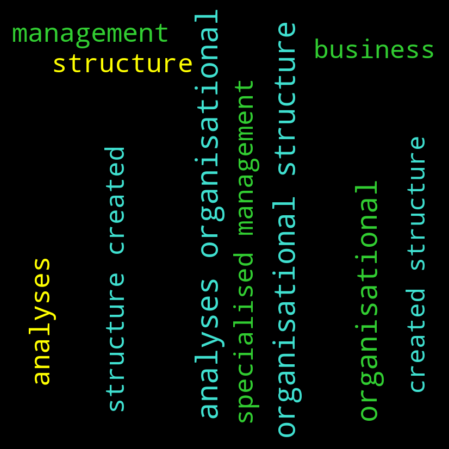

In [33]:
print("\n====== Paper keywords ======\n")
_ = train_bert.get_top_words(bert, demo_publication['feature'].iloc[0], publications=demo_publication,
                             ngram_range=(1, 2), figsize=(8, 8), plot=True, top_words=10, colormap=colormap)

In [24]:
import seaborn as sns

for min_num_publications in [1, 3, 5, 7, 10, 15, 20, 25, 35, 50, 75, 100]:
    false_positives = authors_negative_bert_cv[authors_negative_bert_cv['score'] >= bert.cfg.threshold]
    false_negatives = authors_bert_cv[authors_bert_cv['score'] < bert.cfg.threshold]

    users_features_bert['num_publications'] = users_features_bert['publication_ids'].apply(len)
    users_features_bert['num_publications'].describe()

    users_features_bert_many_publications = users_features_bert[\
        users_features_bert['num_publications'] >= min_num_publications]

    authors_negative_bert_cv_many_publications = authors_negative_bert_cv[\
        authors_negative_bert_cv['user_id'].apply(\
            lambda user_id: user_id in users_features_bert_many_publications.index)]
    authors_bert_cv_many_publications = authors_bert_cv[\
        authors_bert_cv['user_id'].apply(\
            lambda user_id: user_id in users_features_bert_many_publications.index)]

    false_positives_many_publications = false_positives[\
        false_positives['user_id'].apply(lambda user_id: user_id in users_features_bert_many_publications.index)]
    false_negatives_many_publications = false_negatives[\
        false_negatives['user_id'].apply(lambda user_id: user_id in users_features_bert_many_publications.index)]
    
    print(f"{min_num_publications} min publications: "+
          f"{len(authors_bert_cv_many_publications)} total positives; "+
          f"{len(authors_negative_bert_cv_many_publications)} total negatives; "+
          f"{len(false_positives_many_publications)} fp; "+
          f"{len(false_negatives_many_publications)} fn; "+
          f"{len(false_positives_many_publications)/len(authors_negative_bert_cv_many_publications)} fp rate; "+
          f"{len(false_negatives_many_publications)/len(authors_bert_cv_many_publications)} fn rate; ")


1 min publications: 13303 total positives; 1742 total negatives; 927 fp; 540 fn; 0.5321469575200919 fp rate; 0.040592347590769 fn rate; 
3 min publications: 10942 total positives; 1490 total negatives; 801 fp; 385 fn; 0.5375838926174497 fp rate; 0.03518552367026138 fn rate; 
5 min publications: 9751 total positives; 1396 total negatives; 749 fp; 335 fn; 0.5365329512893983 fp rate; 0.03435545072300277 fn rate; 
7 min publications: 8994 total positives; 1313 total negatives; 728 fp; 318 fn; 0.5544554455445545 fp rate; 0.035356904603068715 fn rate; 
10 min publications: 8039 total positives; 1125 total negatives; 663 fp; 295 fn; 0.5893333333333334 fp rate; 0.036696106480905585 fn rate; 
15 min publications: 7028 total positives; 949 total negatives; 571 fp; 264 fn; 0.6016859852476291 fp rate; 0.037564029595902104 fn rate; 
20 min publications: 6093 total positives; 777 total negatives; 470 fp; 223 fn; 0.6048906048906049 fp rate; 0.036599376333497455 fn rate; 
25 min publications: 5457 tot

In [8]:
import itertools
import time
%reload train_bert
import train_bert
pca_num_components = [5, 10, 12, 15, 20, 25, 35, 50, 75, 100]
normalize_features = [False, True]
metric = ['dot', 'cos', 'norm']
choices = list(itertools.product(pca_num_components, normalize_features, metric))
np.random.shuffle(choices)
results = []
filename = f"results_bert_{int(time.time())}"
i = 0
for pca_num_components, normalize_features, metric in tqdm(choices):
    bert_conf = train_bert.BERTConfig()
    bert_conf.embedding_model = "all-mpnet-base-v2"
    bert_conf.device = "cuda"
    bert_conf.pca_num_components = pca_num_components
    bert_conf.batch_size = 32
    bert_conf.fpr_samples_from = 0
    bert_conf.fpr_samples_to = 1
    bert_conf.fpr_samples_count = 1000
    bert_conf.normalize_features = normalize_features
    bert_conf.metric = metric
    
    _, _, _, _, _, _, performance_report = \
        train_bert.train_and_evaluate_bert(\
            publications_bert_train, publications_bert_cv, authors_bert_train, authors_bert_cv,
            authors_negative_bert_cv, users, bert_conf, save_model=False, plot=False,
            random_negative_examples=False, recalculate_embeddings=False, progress=False)

    results.append(performance_report)
    print(performance_report)
    common.save_pickle(results, f"{filename}_{i}.pickle")
    i += 1

  0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import itertools
import time
num_topics_values = [5, 10, 15, 25, 50, 200]
no_below_values = [5, 20, 50, 100]
no_above_values = [0.3, 0.5, 0.75]
choices = list(itertools.product(num_topics_values, no_below_values, no_above_values))
np.random.shuffle(choices)
results = []
filename = f"results_{int(time.time())}"
i = 0
for num_topics, no_below, no_above in tqdm(choices):
    conf = train_lda.LDAConfig()
    conf.num_topics = num_topics
    conf.chunksize = 5000
    conf.passes = 4
    conf.iterations = 400
    conf.eval_every = 1
    conf.no_below = no_below
    conf.no_above = no_above
    conf.num_negative_examples_to_positive_examples = 1
    conf.fpr_samples_from = 0
    conf.fpr_samples_to = 0.5
    conf.fpr_samples_count = 201
    result = train_lda.train_and_evaluate_lda(publications_train, publications_cv, authors_train, authors_cv, users, conf, debug_logging=False)
    results.append(result)
    print(result)
    common.save_pickle(results, f"{filename}_{i}.pickle")
    i += 1


In [7]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)

In [8]:
docs = publications_bert['abstract_text_clean'].tolist()

In [9]:
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/1117 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [47]:
from sklearn.cluster import KMeans

embeddings_size = publications_bert_train['embeddings'].iloc[0].shape[0]
publications_bert_train_features = np.zeros((len(publications_bert_train), embeddings_size))
for i in range(len(publications_bert_train)):
    publications_bert_train_features[i, :] = publications_bert_train['embeddings'].iloc[i]


kmeans = KMeans(n_clusters=10, random_state=42).fit(publications_bert_train_features)
kmeans

KMeans(n_clusters=10, random_state=42)

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(publications_bert_train['abstract_text_clean'])
dictionary = vectorizer.get_feature_names_out().tolist()
analyzer = vectorizer.build_analyzer()

texts = []
for i in tqdm(range(len(publications_bert_train))):
    texts.append(analyzer(publications_bert_train['abstract_text_clean'].iloc[i]))

  0%|          | 0/21428 [00:00<?, ?it/s]

In [49]:
%reload train_bert
import train_bert

topics = []

word_embeddings, words = train_bert.eval_features_for_words(bert, texts, ngram_range=(1, 1))

for i in range(kmeans.cluster_centers_.shape[0]):
    topic_feature = kmeans.cluster_centers_[i, :]
    topics.append(train_bert.get_top_words(bert,
                                           topic_feature, 
                                           word_embeddings=word_embeddings,
                                           words=words,
                                           ngram_range=(1, 1),
                                           plot=False).index.tolist())
topics

2022-06-20 09:22:51,712 : DEBUG : reloading module: train_bert


Batches:   0%|          | 0/1840 [00:00<?, ?it/s]

ValueError: shapes (384,) and (15,384) not aligned: 384 (dim 0) != 15 (dim 0)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora

dictionary_gensim = corpora.Dictionary(texts)

In [ ]:
topicscm = CoherenceModel(topics=topics, texts=[t for t in texts if len(t) > 0],
                    dictionary=dictionary_gensim, coherence='c_npmi')

In [ ]:
coherence = cm.get_coherence()  # get coherence value

In [45]:
coherence

-0.21106930174145902

In [180]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [181]:
dir(newsgroups_train)

['DESCR', 'data', 'filenames', 'target', 'target_names']

In [182]:
type(newsgroups_train.DESCR)

str

In [183]:
print(newsgroups_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [184]:
newsgroups = pd.DataFrame(newsgroups_train.data, columns=["abstract_text"])
newsgroups

abstract_text
0      From: lerxst@wam.umd.edu (where's my thing)\nS...
1      From: guykuo@carson.u.washington.edu (Guy Kuo)...
2      From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3      From: jgreen@amber (Joe Green)\nSubject: Re: W...
4      From: jcm@head-cfa.harvard.edu (Jonathan McDow...
...                                                  ...
11309  From: jim.zisfein@factory.com (Jim Zisfein) \n...
11310  From: ebodin@pearl.tufts.edu\nSubject: Screen ...
11311  From: westes@netcom.com (Will Estes)\nSubject:...
11312  From: steve@hcrlgw (Steven Collins)\nSubject: ...
11313  From: gunning@cco.caltech.edu (Kevin J. Gunnin...

[11314 rows x 1 columns]

In [185]:
newsgroups_preprocessed = preprocess_bert.preprocess_bert(newsgroups)
newsgroups_preprocessed

  0%|          | 0/11314 [00:00<?, ?it/s]

abstract_text  \
0      From: lerxst@wam.umd.edu (where's my thing)\nS...   
1      From: guykuo@carson.u.washington.edu (Guy Kuo)...   
2      From: twillis@ec.ecn.purdue.edu (Thomas E Will...   
3      From: jgreen@amber (Joe Green)\nSubject: Re: W...   
4      From: jcm@head-cfa.harvard.edu (Jonathan McDow...   
...                                                  ...   
11309  From: jim.zisfein@factory.com (Jim Zisfein) \n...   
11310  From: ebodin@pearl.tufts.edu\nSubject: Screen ...   
11311  From: westes@netcom.com (Will Estes)\nSubject:...   
11312  From: steve@hcrlgw (Steven Collins)\nSubject: ...   
11313  From: gunning@cco.caltech.edu (Kevin J. Gunnin...   

                                     abstract_text_clean  
0      From: lerxst@wam.umd.edu (where's my thing)\nS...  
1      From: guykuo@carson.u.washington.edu (Guy Kuo)...  
2      From: twillis@ec.ecn.purdue.edu (Thomas E Will...  
3      From: jgreen@amber (Joe Green)\nSubject: Re: W...  
4      From: jcm@head-cfa.harvard.edu (Jonathan McDow...  
...                                                  ...  
11309  From: jim.zisfein@factory.com (Jim Zisfein) \n...  
11310  From: ebodin@pearl.tufts.edu\nSubject: Screen ...  
11311  From: westes@netcom.com (Will Estes)\nSubject:...  
11312  From: steve@hcrlgw (Steven Collins)\nSubject: ...  
11313  From: gunning@cco.caltech.edu (Kevin J. Gunnin...  

[11314 rows x 2 columns]

In [194]:
bert_conf = train_bert.BERTConfig()
bert_conf.embedding_model = "all-MiniLM-L6-v2"
bert_conf.device = "cuda"
bert_conf.n_components = 12
bert_conf.batch_size = 32
bert_conf.fpr_samples_from = 0
bert_conf.fpr_samples_to = 1
bert_conf.fpr_samples_count = 1000
bert_conf.normalize_features = False
bert_conf.metric = "cos"
bert_conf.umap_metric = "cosine"
bert_conf.reducer = "pca"
bert_conf.use_scaler = False
bert_conf.umap_min_dist = 0
bert_conf.umap_n_neighbors = 10
bert_conf.clustering_algorithm = "kmeans"
bert_conf.n_clusters = 30
bert_conf.random_state = 1
bert_conf.score = "phi"

newsgroup_bert, newsgroups_preprocessed = \
    train_bert.train_bert(newsgroups_preprocessed,
         bert_conf,
         recalculate_embeddings=False,
         progress=True)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11314/11314 [00:01<00:00, 9556.31it/s]
/home/david/PycharmProjects/licenta/common.py:86: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

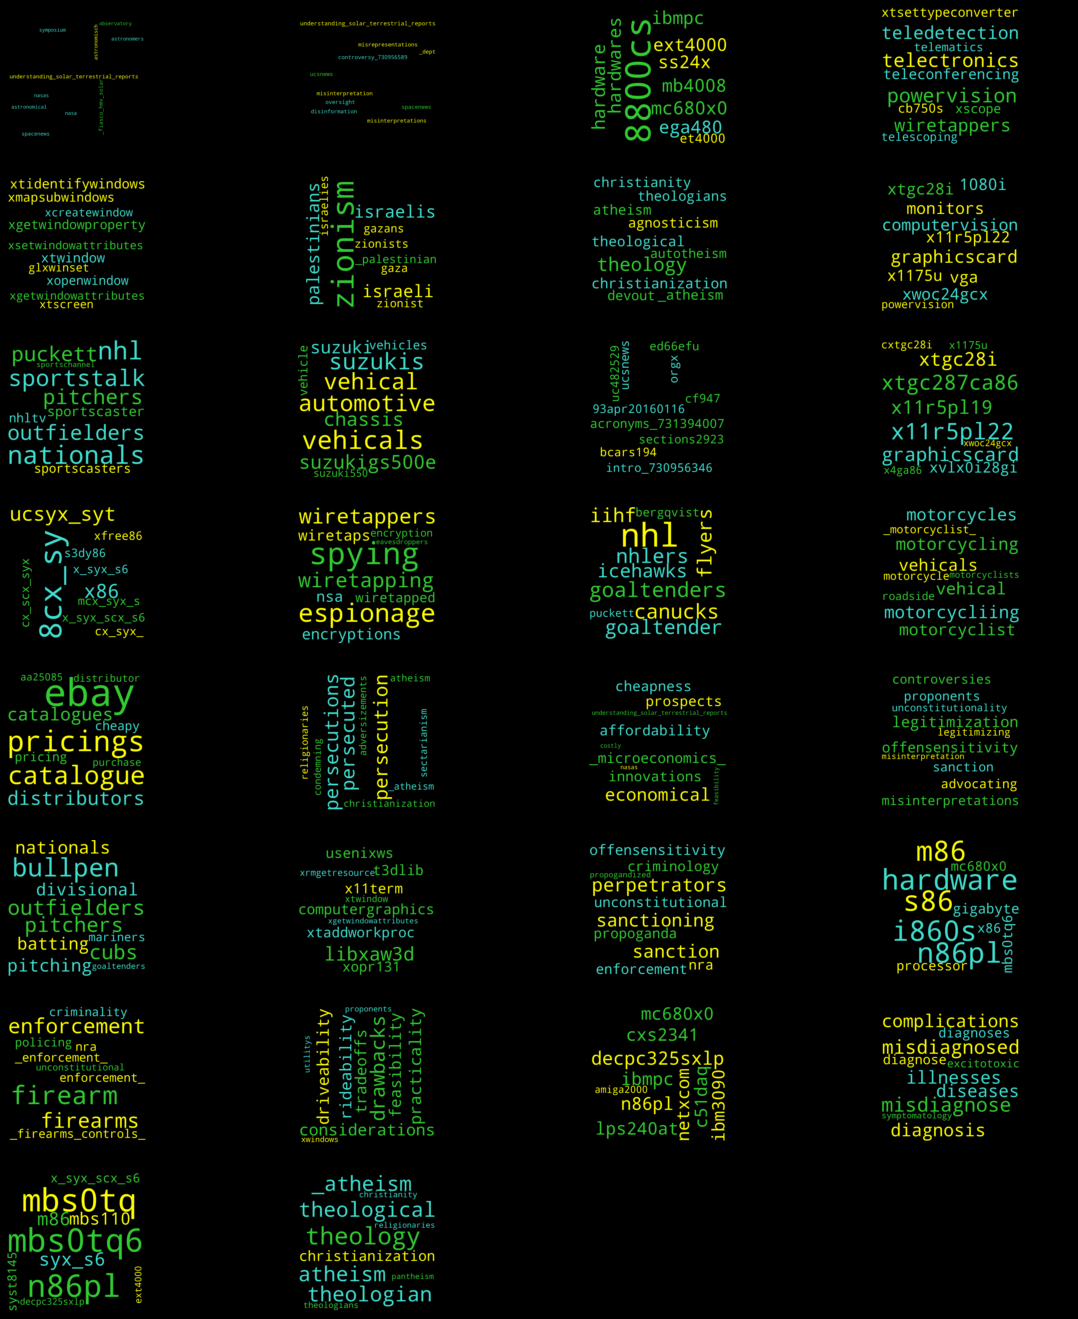

In [195]:
coherence, word_embeddings_newsgroup, words_newsgroup = \
    train_bert.get_coherence(
        newsgroup_bert,
        publications_bert_train_abstracts=newsgroups_preprocessed['abstract_text_clean'],
        word_embeddings=word_embeddings_newsgroup, words=words_newsgroup, coherence="c_npmi",
        plot=True, figsize=(20, 24), top_words=10, colormap=colormap)
print(f"Coherence = {coherence}")

In [118]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [ ]:
topics_reducer = {
    0: 15,# alt.atheism -> soc.religion.christian
    2: 5, # comp.os.ms-windows.misc -> comp.windows.x
    3: 4, # comp.sys.ibm.pc.hardware -> comp.sys.mac.hardware
    4: 3,
    5: 2,
    6: 4, # misc.forsale
    7: 5, # rec.autos
    8: 6, # rec.motorcycles
    9: 7,
    10: 8,
    11: 9
}

In [196]:
topic_associations = [
    'sci.space',
    'sci.space',
    'comp.sys.ibm.pc.hardware',
    'sci.electronics',
    'comp.sys.mac.hardware',
    'talk.politics.mideast',
    'talk.religion.misc',
    'comp.graphics',
    'rec.sport.baseball',
    'rec.autos',
    'comp.sys.mac.hardware',
    'comp.sys.mac.hardware',
    'comp.os.ms-windows.misc',
    'sci.crypt',
    'rec.sport.hockey',
    'rec.motorcycles',
    'misc.forsale',
    'talk.religion.misc',
    'talk.politics.misc',
    'talk.politics.misc',
    'rec.sport.baseball',
    'comp.graphics',
    'talk.politics.misc',
    'comp.sys.mac.hardware',
    'talk.politics.guns',
    'talk.politics.misc',
    'comp.sys.ibm.pc.hardware',
    'sci.med',
    'comp.windows.x',
    'alt.atheism',
]

In [197]:
%reload common
import common

X = common.series_to_matrix(newsgroups_preprocessed['feature'])

In [198]:
topic_names = [topic_associations[idx] for idx in newsgroup_bert.kmeans.predict(X).tolist()]
topic_ids = [newsgroups_train.target_names.index(topic_name) for topic_name in topic_names]
topic_ids

[7,
 4,
 3,
 1,
 14,
 16,
 13,
 4,
 1,
 4,
 7,
 19,
 2,
 18,
 6,
 19,
 2,
 7,
 12,
 4,
 19,
 10,
 3,
 4,
 5,
 3,
 4,
 9,
 0,
 7,
 18,
 13,
 18,
 17,
 18,
 10,
 7,
 11,
 8,
 16,
 18,
 3,
 5,
 9,
 9,
 6,
 1,
 7,
 18,
 14,
 4,
 19,
 6,
 13,
 17,
 11,
 8,
 9,
 2,
 14,
 6,
 4,
 3,
 6,
 14,
 0,
 4,
 18,
 19,
 6,
 17,
 16,
 18,
 18,
 4,
 3,
 11,
 7,
 4,
 4,
 19,
 18,
 1,
 4,
 18,
 4,
 2,
 4,
 10,
 3,
 3,
 17,
 4,
 5,
 8,
 8,
 18,
 4,
 0,
 1,
 1,
 3,
 7,
 2,
 17,
 4,
 12,
 6,
 4,
 9,
 18,
 12,
 5,
 9,
 9,
 19,
 13,
 11,
 4,
 14,
 0,
 8,
 4,
 0,
 19,
 14,
 18,
 16,
 9,
 8,
 6,
 13,
 3,
 17,
 18,
 19,
 9,
 3,
 4,
 19,
 13,
 9,
 4,
 8,
 4,
 13,
 1,
 18,
 0,
 18,
 18,
 14,
 17,
 4,
 4,
 3,
 7,
 0,
 2,
 19,
 17,
 16,
 4,
 0,
 9,
 12,
 6,
 4,
 4,
 6,
 18,
 1,
 10,
 6,
 10,
 4,
 4,
 13,
 4,
 9,
 13,
 8,
 13,
 8,
 5,
 4,
 9,
 1,
 12,
 3,
 4,
 4,
 18,
 13,
 5,
 2,
 12,
 19,
 16,
 6,
 16,
 7,
 14,
 19,
 11,
 18,
 5,
 13,
 10,
 18,
 19,
 4,
 16,
 4,
 1,
 13,
 8,
 4,
 13,
 17,
 2,
 19,
 2,
 14,
 9,
 16,
 

In [199]:
newsgroups_train.target

array([7, 4, 4, ..., 3, 1, 8])

In [200]:
print(newsgroups_train.data[1])

From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.edu>



In [201]:
import umap

In [202]:
reducer = umap.UMAP(n_components=2, min_dist=0, metric='euclidean')
Xp = reducer.fit_transform(X, newsgroups_train.target)
Xp

array([[11.0641165 , 14.238513  ],
       [ 5.613355  , 13.926124  ],
       [ 5.154687  , 13.449968  ],
       ...,
       [ 4.4063416 , 16.790073  ],
       [ 0.27521288, 14.300754  ],
       [15.933195  , 12.984118  ]], dtype=float32)

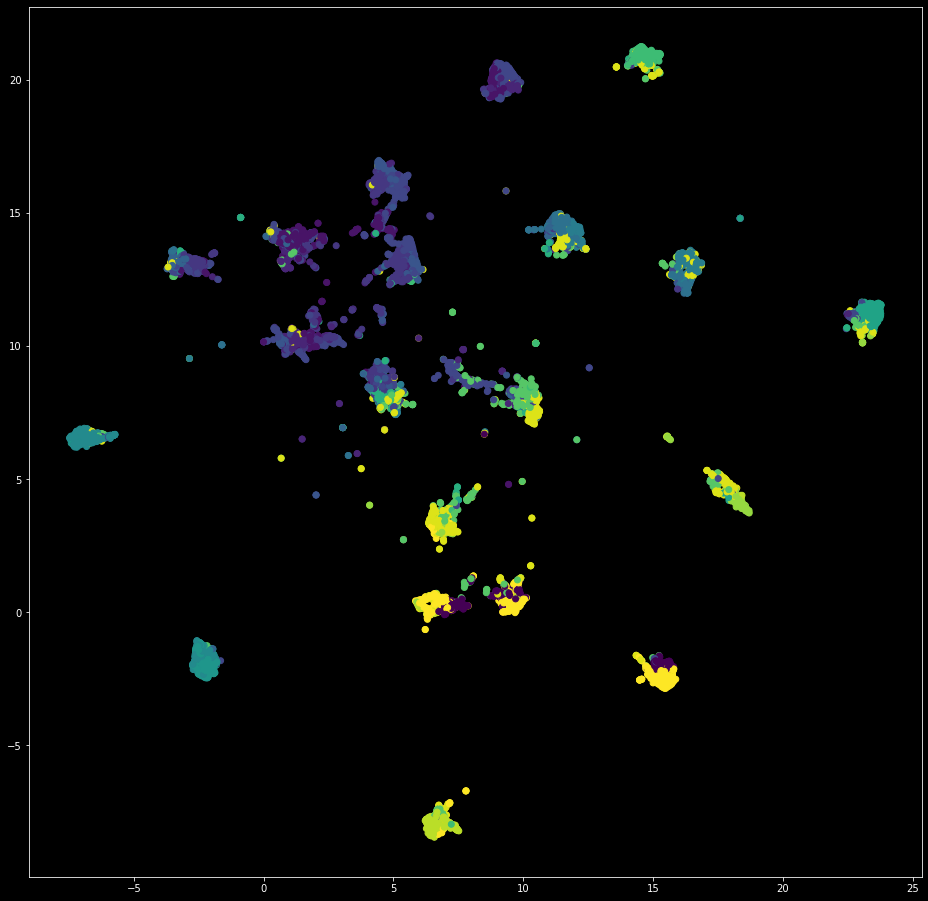

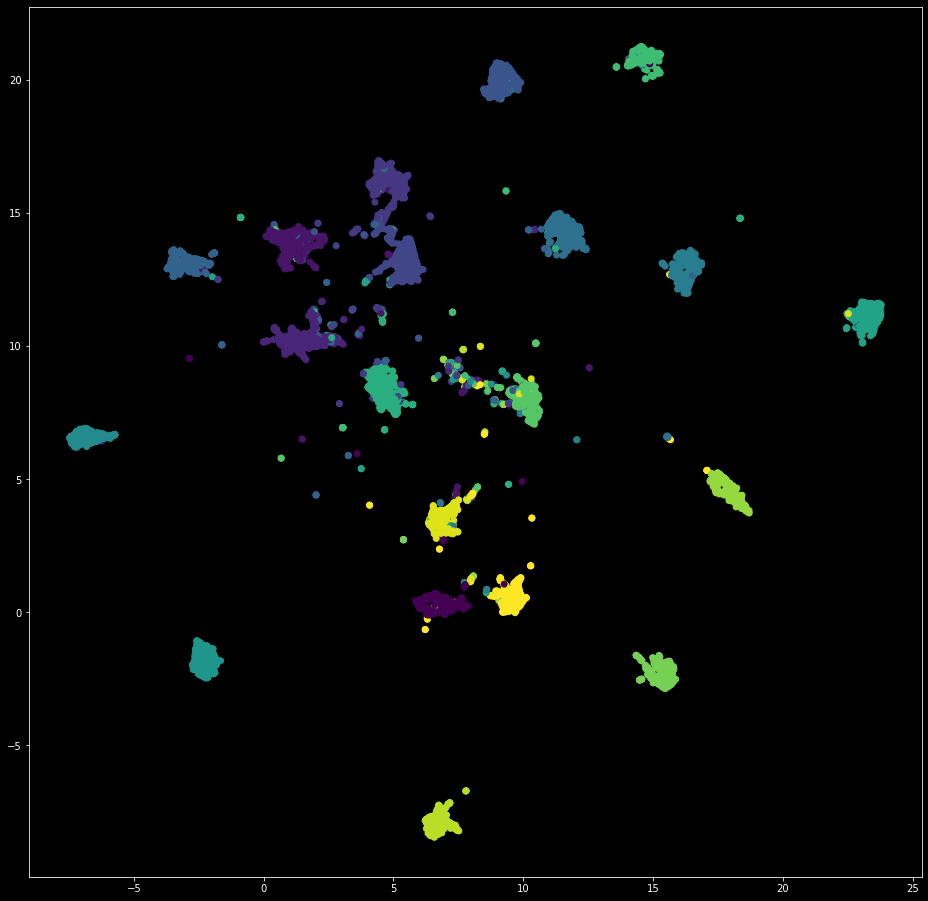

In [203]:
plt.figure(figsize=(16, 16))
plt.scatter(Xp[:, 0], Xp[:, 1], c=topic_ids)
plt.figure(figsize=(16, 16))
plt.scatter(Xp[:, 0], Xp[:, 1], c=newsgroups_train.target)